# Scout Experiments

## Quick and dirty to compare optimizers

Just to see if the idea even works, it was a success. 

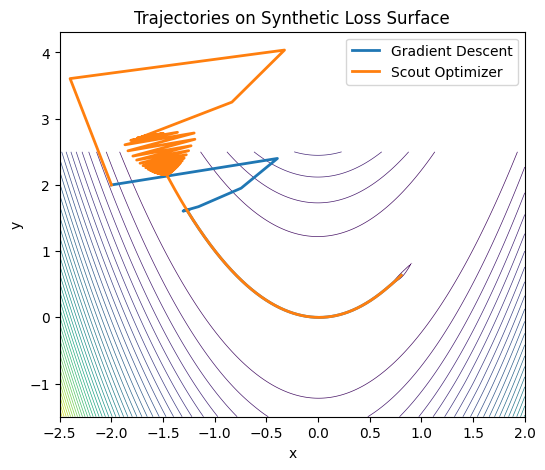

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ---- Synthetic 2-D non-convex loss surface --------------------
def loss_fn(p):
    """
    Rosenbrock valley + three narrow sharp pits.
    p: array-like shape (2,)
    """
    x, y = p
    # Rosenbrock
    rb = (1 - x)**2 + 100 * (y - x**2)**2
    # Sharp pits (negative Gaussians)
    pit1 = -3.0 * np.exp(-((x - 1.5)**2 + (y + 1.0)**2) / 0.02)
    pit2 = -2.5 * np.exp(-((x + 0.5)**2 + (y + 1.5)**2) / 0.02)
    pit3 = -2.8 * np.exp(-((x - 1.0)**2 + (y - 0.5)**2) / 0.02)
    return rb + pit1 + pit2 + pit3

def grad_fn(p):
    """Analytic gradient of loss_fn."""
    x, y = p
    # Rosenbrock gradient
    dL_dx = -2*(1 - x) - 400*x*(y - x**2)
    dL_dy = 200*(y - x**2)
    
    # Gaussians
    g1 = np.exp(-((x - 1.5)**2 + (y + 1.0)**2) / 0.02)
    g2 = np.exp(-((x + 0.5)**2 + (y + 1.5)**2) / 0.02)
    g3 = np.exp(-((x - 1.0)**2 + (y - 0.5)**2) / 0.02)
    
    dL_dx += 3.0 * 2*(x - 1.5)/0.02 * g1
    dL_dy += 3.0 * 2*(y + 1.0)/0.02 * g1
    
    dL_dx += 2.5 * 2*(x + 0.5)/0.02 * g2
    dL_dy += 2.5 * 2*(y + 1.5)/0.02 * g2
    
    dL_dx += 2.8 * 2*(x - 1.0)/0.02 * g3
    dL_dy += 2.8 * 2*(y - 0.5)/0.02 * g3
    return np.array([dL_dx, dL_dy])

# ---- Baseline Gradient Descent -------------------------------
def gd(start, lr=1e-3, steps=8000):
    traj = [np.array(start)]
    p = np.array(start, dtype=float)
    for _ in range(steps):
        p = p - lr * grad_fn(p)
        traj.append(p.copy())
    return np.array(traj)

# ---- Scout-guided Optimizer ----------------------------------
def scout_opt(start, lr=1e-3, steps=8000, scout_every=50, scout_radius=0.05, lookahead_steps=10):
    traj = [np.array(start)]
    p = np.array(start, dtype=float)
    grad = grad_fn(p)
    dim = len(p)
    
    rng = np.random.default_rng(0)
    
    for step in range(steps):
        if step % scout_every == 0:
            # Build candidate directions: gradient + up to dim orthogonal random dirs
            dirs = []
            g_norm = np.linalg.norm(grad)
            if g_norm > 0:
                dirs.append(grad / g_norm)
            # Generate one random orthogonal direction
            rand_dir = rng.normal(size=dim)
            rand_dir = rand_dir - rand_dir.dot(dirs[0]) * dirs[0]
            if np.linalg.norm(rand_dir) > 0:
                rand_dir /= np.linalg.norm(rand_dir)
                dirs.append(rand_dir)
            
            # Evaluate each direction with a short simulation
            best_dir = dirs[0]
            best_future_loss = np.inf
            current_loss = loss_fn(p)
            for d in dirs:
                p_probe = p.copy()
                # small initial step
                p_probe = p_probe - scout_radius * d
                # unroll lookahead steps with vanilla GD
                for _ in range(lookahead_steps):
                    p_probe = p_probe - lr * grad_fn(p_probe)
                future_loss = loss_fn(p_probe)
                # cost: future loss; allow slightly worse than current by margin
                if future_loss < best_future_loss:
                    best_future_loss = future_loss
                    best_dir = d
            # Replace gradient with scaled best_dir
            grad = best_dir * g_norm  # keep magnitude
        else:
            grad = grad_fn(p)
        
        p = p - lr * grad
        traj.append(p.copy())
    return np.array(traj)

# ---- Run both optimizers -------------------------------------
start_point = (-2.0, 2.0)
traj_gd = gd(start_point)
traj_scout = scout_opt(start_point)

# ---- Plotting ------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 5))

# Contour of loss surface
xgrid = np.linspace(-2.5, 2.0, 400)
ygrid = np.linspace(-1.5, 2.5, 400)
X, Y = np.meshgrid(xgrid, ygrid)
Z = loss_fn((X, Y))
CS = ax.contour(X, Y, Z, levels=50, linewidths=0.5)

# Plot trajectories
ax.plot(traj_gd[:, 0], traj_gd[:, 1], label="Gradient Descent", linewidth=2)
ax.plot(traj_scout[:, 0], traj_scout[:, 1], label="Scout Optimizer", linewidth=2)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Trajectories on Synthetic Loss Surface')
ax.legend()

plt.show()


# Only scout running a CNN

Seeing if the optimizer can train a CNN. It can. 

In [2]:
"""scout_opt_cifar10.py

Quick‑and‑dirty *large(-ish)* demo of the scout–guided optimizer on CIFAR‑10.

• Dataset  : CIFAR‑10 (50 k train / 10 k test, 32×32 colour)
• Model    : lightweight CNN (~0.6 M params)
• Baseline : Adam
• ScoutOpt : wraps Adam, periodically probes 2 directions
             (current grad + one random orthogonal) with
             a 1‑step look‑ahead on the same mini‑batch.

Run from a Jupyter cell (accepts the stray -f arg) or from CLI:
    python scout_opt_cifar10.py --gpu  

-------------------------------------------------------"""

import argparse, time, pathlib, random, sys
from typing import List

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# ------------------------------------------------------------------ #
#  1. A small-ish CNN                                                #
# ------------------------------------------------------------------ #
class SmallCNN(nn.Module):
    def __init__(self, n_classes: int = 10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.fc1   = nn.Linear(256 * 4 * 4, 256)
        self.fc2   = nn.Linear(256, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32→16
        x = self.pool(F.relu(self.conv2(x)))  # 16→8
        x = self.pool(F.relu(self.conv3(x)))  # 8 →4
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# ------------------------------------------------------------------ #
#  2. Scout‑guided Optimizer                                         #
# ------------------------------------------------------------------ #
class ScoutOptimizer(optim.Optimizer):
    """Light wrapper that adds a cheap 1‑step look‑ahead probe."""

    def __init__(self, params, base_opt_cls, *, lr=3e-4, scout_every=100, scout_radius=5e-4, **base_kwargs):
        param_list = list(params)
        self.base = base_opt_cls(param_list, lr=lr, **base_kwargs)
        super().__init__(param_list, defaults=dict(lr=lr))
        self.s_every  = scout_every
        self.radius   = scout_radius
        self._step_id = 0
        self._params  = param_list

    @staticmethod
    @torch.no_grad()
    def _flatten(tensors: List[torch.Tensor]):
        return torch.cat([t.reshape(-1) for t in tensors])

    @torch.no_grad()
    def _apply_delta(self, vec_flat: torch.Tensor, coef: float):
        offset = 0
        for p in self._params:
            n = p.numel()
            p.add_(vec_flat[offset:offset+n].view_as(p), alpha=coef)
            offset += n

    @staticmethod
    @torch.no_grad()
    def _rand_orthogonal(base: torch.Tensor):
        r = torch.randn_like(base)
        proj = (r @ base) / (base @ base + 1e-12)
        ortho = r - proj * base
        return ortho / (ortho.norm() + 1e-12)

    def step(self, closure=None):
        if closure is None:
            raise RuntimeError("ScoutOptimizer needs a closure that returns loss and does backward()")

        loss = closure()
        self._step_id += 1

        if self._step_id % self.s_every == 0:
            grad_flat = self._flatten([p.grad for p in self._params])
            grad_norm = grad_flat.norm() + 1e-12
            grad_dir  = grad_flat / grad_norm
            dirs = [grad_dir, self._rand_orthogonal(grad_dir)]

            best_dir, best_loss = None, loss.item()
            for d in dirs:
                self._apply_delta(d, +self.radius)
                probe_loss = closure()
                self._apply_delta(d, -self.radius)
                if probe_loss < best_loss:
                    best_loss = probe_loss
                    best_dir  = d
            if best_dir is not None:
                new_grad = best_dir * grad_norm
                offset = 0
                for p in self._params:
                    n = p.numel()
                    p.grad.copy_(new_grad[offset:offset+n].view_as(p))
                    offset += n

        self.base.step()
        return loss

# ------------------------------------------------------------------ #
#  3. Training / evaluation loops                                    #
# ------------------------------------------------------------------ #
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    tot_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        tot_loss += criterion(out, y).item() * x.size(0)
        pred = out.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return tot_loss / total, correct / total


def train_one_epoch(model, loader, criterion, opt, device, log_every=100):
    model.train()
    running = 0.0
    for i, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        def closure():
            opt.base.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            return loss
        loss = opt.step(closure)
        running += loss.item()
        if (i + 1) % log_every == 0:
            print(f"  batch {i+1}/{len(loader)}  loss {running/log_every:.3f}")
            running = 0.0

# ------------------------------------------------------------------ #
#  4. Main                                                           #
# ------------------------------------------------------------------ #

def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('--epochs', type=int, default=6)
    parser.add_argument('--batch',  type=int, default=128)
    parser.add_argument('--lr',     type=float, default=3e-4)
    parser.add_argument('--scout_every',  type=int, default=100)
    parser.add_argument('--scout_radius', type=float, default=5e-4)
    parser.add_argument('--gpu', action='store_true')
    args, _ = parser.parse_known_args()

    device = torch.device('cuda' if args.gpu and torch.cuda.is_available() else 'cpu')
    print('Device:', device)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))
    ])

    root = str(pathlib.Path.home() / ".torchdata")
    train_set = datasets.CIFAR10(root=root, train=True,  download=True, transform=transform)
    test_set  = datasets.CIFAR10(root=root, train=False, download=True, transform=transform)

    train_loader = DataLoader(train_set, batch_size=args.batch, shuffle=True,  num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_set,  batch_size=256,       shuffle=False, num_workers=2, pin_memory=True)

    model = SmallCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    opt = ScoutOptimizer(model.parameters(), optim.Adam,
                         lr=args.lr,
                         scout_every=args.scout_every,
                         scout_radius=args.scout_radius,
                         betas=(0.9, 0.999), weight_decay=1e-4)

    for ep in range(1, args.epochs+1):
        print(f"\nEpoch {ep}/{args.epochs}")
        start = time.time()
        train_one_epoch(model, train_loader, criterion, opt, device)
        val_loss, val_acc = evaluate(model, test_loader, criterion, device)
        print(f"  val_loss={val_loss:.3f}  val_acc={val_acc:.3f}  ({time.time() - start:.1f}s)")

    torch.save(model.state_dict(), "scout_cnn.pth")
    print("Model saved to scout_cnn.pth")


if __name__ == '__main__':
    if sys.argv[0].endswith("ipykernel_launcher.py"):
        sys.argv = ['scout_opt_cifar10.py', '--gpu']
        #sys.argv = ['scout_opt_cifar10.py']
    main()

Device: cuda
Files already downloaded and verified
Files already downloaded and verified

Epoch 1/6
  batch 100/391  loss 1.812
  batch 200/391  loss 1.470
  batch 300/391  loss 1.347
  val_loss=1.213  val_acc=0.570  (17.0s)

Epoch 2/6
  batch 100/391  loss 1.164
  batch 200/391  loss 1.093
  batch 300/391  loss 1.053
  val_loss=0.996  val_acc=0.652  (17.2s)

Epoch 3/6
  batch 100/391  loss 0.920
  batch 200/391  loss 0.900
  batch 300/391  loss 0.875
  val_loss=0.909  val_acc=0.685  (15.7s)

Epoch 4/6
  batch 100/391  loss 0.795
  batch 200/391  loss 0.767
  batch 300/391  loss 0.771
  val_loss=0.805  val_acc=0.721  (16.8s)

Epoch 5/6
  batch 100/391  loss 0.679
  batch 200/391  loss 0.682
  batch 300/391  loss 0.675
  val_loss=0.753  val_acc=0.741  (16.2s)

Epoch 6/6
  batch 100/391  loss 0.605
  batch 200/391  loss 0.595
  batch 300/391  loss 0.585
  val_loss=0.730  val_acc=0.750  (16.0s)
Model saved to scout_cnn.pth


# Test without graphs between Scout and Adam

Seeing if they lead to different outcomes. They do. Scout is better.

In [3]:
"""scout_opt_cifar10.py

Quick‑and‑dirty *large(-ish)* demo of the scout–guided optimizer on CIFAR‑10.

• Dataset  : CIFAR‑10 (50 k train / 10 k test, 32×32 colour)
• Model    : lightweight CNN (~0.6 M params)
• Baseline : Adam
• ScoutOpt : wraps Adam, periodically probes 2 directions
             (current grad + one random orthogonal) with
             a 1‑step look‑ahead on the same mini‑batch.

Run from a Jupyter cell (accepts the stray -f arg) or from CLI:
    python scout_opt_cifar10.py --gpu  

-------------------------------------------------------"""

import argparse, time, pathlib, random, sys
from typing import List

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# ------------------------------------------------------------------ #
#  1. A small-ish CNN                                                #
# ------------------------------------------------------------------ #
class SmallCNN(nn.Module):
    def __init__(self, n_classes: int = 10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.fc1   = nn.Linear(256 * 4 * 4, 256)
        self.fc2   = nn.Linear(256, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32→16
        x = self.pool(F.relu(self.conv2(x)))  # 16→8
        x = self.pool(F.relu(self.conv3(x)))  # 8 →4
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# ------------------------------------------------------------------ #
#  2. Scout‑guided Optimizer                                         #
# ------------------------------------------------------------------ #
class ScoutOptimizer(optim.Optimizer):
    """Light wrapper that adds a cheap 1‑step look‑ahead probe."""

    def __init__(self, params, base_opt_cls, *, lr=3e-4, scout_every=100, scout_radius=5e-4, **base_kwargs):
        param_list = list(params)
        self.base = base_opt_cls(param_list, lr=lr, **base_kwargs)
        super().__init__(param_list, defaults=dict(lr=lr))
        self.s_every  = scout_every
        self.radius   = scout_radius
        self._step_id = 0
        self._params  = param_list

    @staticmethod
    @torch.no_grad()
    def _flatten(tensors: List[torch.Tensor]):
        return torch.cat([t.reshape(-1) for t in tensors])

    @torch.no_grad()
    def _apply_delta(self, vec_flat: torch.Tensor, coef: float):
        offset = 0
        for p in self._params:
            n = p.numel()
            p.add_(vec_flat[offset:offset+n].view_as(p), alpha=coef)
            offset += n

    @staticmethod
    @torch.no_grad()
    def _rand_orthogonal(base: torch.Tensor):
        r = torch.randn_like(base)
        proj = (r @ base) / (base @ base + 1e-12)
        ortho = r - proj * base
        return ortho / (ortho.norm() + 1e-12)

    def step(self, closure=None):
        if closure is None:
            raise RuntimeError("ScoutOptimizer needs a closure that returns loss and does backward()")

        loss = closure()
        self._step_id += 1

        if self._step_id % self.s_every == 0:
            grad_flat = self._flatten([p.grad for p in self._params])
            grad_norm = grad_flat.norm() + 1e-12
            grad_dir  = grad_flat / grad_norm
            dirs = [grad_dir, self._rand_orthogonal(grad_dir)]

            best_dir, best_loss = None, loss.item()
            for d in dirs:
                self._apply_delta(d, +self.radius)
                probe_loss = closure()
                self._apply_delta(d, -self.radius)
                if probe_loss < best_loss:
                    best_loss = probe_loss
                    best_dir  = d
            if best_dir is not None:
                new_grad = best_dir * grad_norm
                offset = 0
                for p in self._params:
                    n = p.numel()
                    p.grad.copy_(new_grad[offset:offset+n].view_as(p))
                    offset += n

        self.base.step()
        return loss

# ------------------------------------------------------------------ #
#  3. Training / evaluation loops                                    #
# ------------------------------------------------------------------ #
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    tot_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        tot_loss += criterion(out, y).item() * x.size(0)
        pred = out.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return tot_loss / total, correct / total


def train_one_epoch(model, loader, criterion, opt, device, log_every=100):
    model.train()
    running = 0.0
    for i, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        def closure():
            opt.base.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            return loss
        loss = opt.step(closure)
        running += loss.item()
        if (i + 1) % log_every == 0:
            print(f"  batch {i+1}/{len(loader)}  loss {running/log_every:.3f}")
            running = 0.0
# ------------------------------------------------------------------ #
#  4. Baseline Adam Check                                                     #
# ------------------------------------------------------------------ #

def run_baseline_adam(epochs=6, batch=128, lr=3e-4):
    print("\nBaseline: Adam")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))
    ])
    root = str(pathlib.Path.home() / ".torchdata")
    train_set = datasets.CIFAR10(root=root, train=True,  download=True, transform=transform)
    test_set  = datasets.CIFAR10(root=root, train=False, download=True, transform=transform)
    train_loader = DataLoader(train_set, batch_size=batch, shuffle=True,  num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_set,  batch_size=256,   shuffle=False, num_workers=2, pin_memory=True)

    model = SmallCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=1e-4)

    for ep in range(1, epochs+1):
        print(f"\nEpoch {ep}/{epochs}")
        model.train()
        running = 0.0
        for i, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            running += loss.item()
            if (i + 1) % 100 == 0:
                print(f"  batch {i+1}/{len(train_loader)}  loss {running/100:.3f}")
                running = 0.0

        val_loss, val_acc = evaluate(model, test_loader, criterion, device)
        print(f"  val_loss={val_loss:.3f}  val_acc={val_acc:.3f}")

# ------------------------------------------------------------------ #
#  5. Main                                                           #
# ------------------------------------------------------------------ #

def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('--epochs', type=int, default=6)
    parser.add_argument('--batch',  type=int, default=128)
    parser.add_argument('--lr',     type=float, default=3e-4)
    parser.add_argument('--scout_every',  type=int, default=100)
    parser.add_argument('--scout_radius', type=float, default=5e-4)
    parser.add_argument('--gpu', action='store_true')
    args, _ = parser.parse_known_args()

    device = torch.device('cuda' if args.gpu and torch.cuda.is_available() else 'cpu')
    print('Device:', device)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))
    ])

    root = str(pathlib.Path.home() / ".torchdata")
    train_set = datasets.CIFAR10(root=root, train=True,  download=True, transform=transform)
    test_set  = datasets.CIFAR10(root=root, train=False, download=True, transform=transform)

    train_loader = DataLoader(train_set, batch_size=args.batch, shuffle=True,  num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_set,  batch_size=256,       shuffle=False, num_workers=2, pin_memory=True)

    model = SmallCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    opt = ScoutOptimizer(model.parameters(), optim.Adam,
                         lr=args.lr,
                         scout_every=args.scout_every,
                         scout_radius=args.scout_radius,
                         betas=(0.9, 0.999), weight_decay=1e-4)

    for ep in range(1, args.epochs+1):
        print(f"\nEpoch {ep}/{args.epochs}")
        start = time.time()
        train_one_epoch(model, train_loader, criterion, opt, device)
        val_loss, val_acc = evaluate(model, test_loader, criterion, device)
        print(f"  val_loss={val_loss:.3f}  val_acc={val_acc:.3f}  ({time.time() - start:.1f}s)")

    torch.save(model.state_dict(), "scout_cnn.pth")
    print("Model saved to scout_cnn.pth")


if __name__ == '__main__':
    if sys.argv[0].endswith("ipykernel_launcher.py"):
        sys.argv = ['scout_opt_cifar10.py']
    main()
    run_baseline_adam()


Device: cuda
Files already downloaded and verified
Files already downloaded and verified

Epoch 1/6
  batch 100/391  loss 1.817
  batch 200/391  loss 1.466
  batch 300/391  loss 1.342
  val_loss=1.199  val_acc=0.568  (16.5s)

Epoch 2/6
  batch 100/391  loss 1.158
  batch 200/391  loss 1.069
  batch 300/391  loss 1.017
  val_loss=0.971  val_acc=0.651  (16.6s)

Epoch 3/6
  batch 100/391  loss 0.895
  batch 200/391  loss 0.912
  batch 300/391  loss 0.885
  val_loss=0.860  val_acc=0.703  (16.2s)

Epoch 4/6
  batch 100/391  loss 0.770
  batch 200/391  loss 0.760
  batch 300/391  loss 0.767
  val_loss=0.835  val_acc=0.710  (16.4s)

Epoch 5/6
  batch 100/391  loss 0.650
  batch 200/391  loss 0.668
  batch 300/391  loss 0.671
  val_loss=0.775  val_acc=0.734  (16.1s)

Epoch 6/6
  batch 100/391  loss 0.583
  batch 200/391  loss 0.586
  batch 300/391  loss 0.581
  val_loss=0.724  val_acc=0.753  (16.4s)
Model saved to scout_cnn.pth

Baseline: Adam
Files already downloaded and verified
Files alread

# With graphs

Better visualization of the performance of the optimizers.

Device: cuda
Files already downloaded and verified
Files already downloaded and verified

Epoch 1/6
  batch 100/391  loss 1.831
  batch 200/391  loss 1.471
  batch 300/391  loss 1.346
  val_loss=1.182  val_acc=0.579  (19.1s)

Epoch 2/6
  batch 100/391  loss 1.142
  batch 200/391  loss 1.092
  batch 300/391  loss 1.026
  val_loss=0.965  val_acc=0.662  (20.0s)

Epoch 3/6
  batch 100/391  loss 0.922
  batch 200/391  loss 0.897
  batch 300/391  loss 0.852
  val_loss=0.862  val_acc=0.702  (19.5s)

Epoch 4/6
  batch 100/391  loss 0.782
  batch 200/391  loss 0.744
  batch 300/391  loss 0.762
  val_loss=0.789  val_acc=0.729  (20.3s)

Epoch 5/6
  batch 100/391  loss 0.676
  batch 200/391  loss 0.675
  batch 300/391  loss 0.680
  val_loss=0.752  val_acc=0.743  (19.3s)

Epoch 6/6
  batch 100/391  loss 0.584
  batch 200/391  loss 0.589
  batch 300/391  loss 0.580
  val_loss=0.736  val_acc=0.753  (19.5s)
Model saved to scout_cnn.pth

Baseline: Adam
Files already downloaded and verified
Files alread

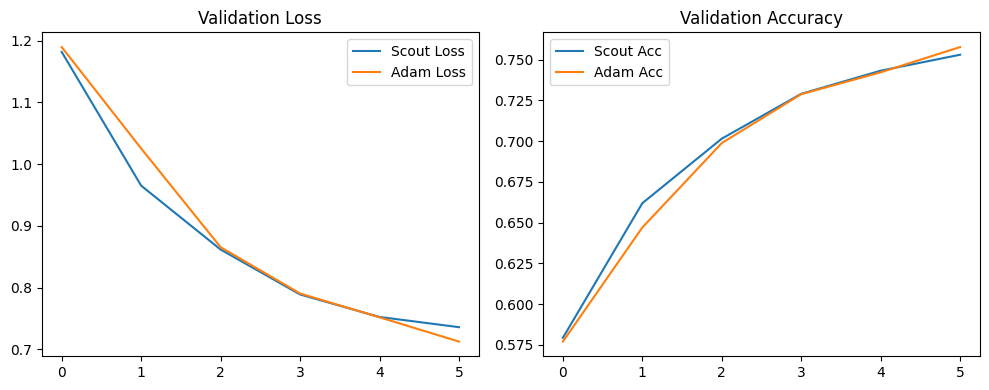

In [4]:
"""scout_opt_cifar10.py

Quick‑and‑dirty *large(-ish)* demo of the scout–guided optimizer on CIFAR‑10.

• Dataset  : CIFAR‑10 (50 k train / 10 k test, 32×32 colour)
• Model    : lightweight CNN (~0.6 M params)
• Baseline : Adam
• ScoutOpt : wraps Adam, periodically probes 2 directions
             (current grad + one random orthogonal) with
             a 1‑step look‑ahead on the same mini‑batch.

Run from a Jupyter cell (accepts the stray -f arg) or from CLI:
    python scout_opt_cifar10.py --gpu  

-------------------------------------------------------"""

import argparse, time, pathlib, random, sys
from typing import List

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# ------------------------------------------------------------------ #
#  1. A small-ish CNN                                                #
# ------------------------------------------------------------------ #
class SmallCNN(nn.Module):
    def __init__(self, n_classes: int = 10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.fc1   = nn.Linear(256 * 4 * 4, 256)
        self.fc2   = nn.Linear(256, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32→16
        x = self.pool(F.relu(self.conv2(x)))  # 16→8
        x = self.pool(F.relu(self.conv3(x)))  # 8 →4
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# ------------------------------------------------------------------ #
#  2. Scout‑guided Optimizer                                         #
# ------------------------------------------------------------------ #
class ScoutOptimizer(optim.Optimizer):
    """Light wrapper that adds a cheap 1‑step look‑ahead probe."""

    def __init__(self, params, base_opt_cls, *, lr=3e-4, scout_every=100, scout_radius=5e-4, **base_kwargs):
        param_list = list(params)
        self.base = base_opt_cls(param_list, lr=lr, **base_kwargs)
        super().__init__(param_list, defaults=dict(lr=lr))
        self.s_every  = scout_every
        self.radius   = scout_radius
        self._step_id = 0
        self._params  = param_list

    @staticmethod
    @torch.no_grad()
    def _flatten(tensors: List[torch.Tensor]):
        return torch.cat([t.reshape(-1) for t in tensors])

    @torch.no_grad()
    def _apply_delta(self, vec_flat: torch.Tensor, coef: float):
        offset = 0
        for p in self._params:
            n = p.numel()
            p.add_(vec_flat[offset:offset+n].view_as(p), alpha=coef)
            offset += n

    @staticmethod
    @torch.no_grad()
    def _rand_orthogonal(base: torch.Tensor):
        r = torch.randn_like(base)
        proj = (r @ base) / (base @ base + 1e-12)
        ortho = r - proj * base
        return ortho / (ortho.norm() + 1e-12)

    def step(self, closure=None):
        if closure is None:
            raise RuntimeError("ScoutOptimizer needs a closure that returns loss and does backward()")

        loss = closure()
        self._step_id += 1

        if self._step_id % self.s_every == 0:
            grad_flat = self._flatten([p.grad for p in self._params])
            grad_norm = grad_flat.norm() + 1e-12
            grad_dir  = grad_flat / grad_norm
            dirs = [grad_dir, self._rand_orthogonal(grad_dir)]

            best_dir, best_loss = None, loss.item()
            for d in dirs:
                self._apply_delta(d, +self.radius)
                probe_loss = closure()
                self._apply_delta(d, -self.radius)
                if probe_loss < best_loss:
                    best_loss = probe_loss
                    best_dir  = d
            if best_dir is not None:
                new_grad = best_dir * grad_norm
                offset = 0
                for p in self._params:
                    n = p.numel()
                    p.grad.copy_(new_grad[offset:offset+n].view_as(p))
                    offset += n

        self.base.step()
        return loss

# ------------------------------------------------------------------ #
#  3. Training / evaluation loops                                    #
# ------------------------------------------------------------------ #
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    tot_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        tot_loss += criterion(out, y).item() * x.size(0)
        pred = out.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return tot_loss / total, correct / total


def train_one_epoch(model, loader, criterion, opt, device, log_every=100):
    model.train()
    running = 0.0
    for i, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        def closure():
            opt.base.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            return loss
        loss = opt.step(closure)
        running += loss.item()
        if (i + 1) % log_every == 0:
            print(f"  batch {i+1}/{len(loader)}  loss {running/log_every:.3f}")
            running = 0.0


# ------------------------------------------------------------------ #
#  4. Baseline Adam Check                                                     #
# ------------------------------------------------------------------ #


def run_baseline_adam(epochs=6, batch=128, lr=3e-4, results=None):
    print("\nBaseline: Adam")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))
    ])
    root = str(pathlib.Path.home() / ".torchdata")
    train_set = datasets.CIFAR10(root=root, train=True,  download=True, transform=transform)
    test_set  = datasets.CIFAR10(root=root, train=False, download=True, transform=transform)
    train_loader = DataLoader(train_set, batch_size=batch, shuffle=True,  num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_set,  batch_size=256,   shuffle=False, num_workers=2, pin_memory=True)

    model = SmallCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=1e-4)

    for ep in range(1, epochs+1):
        print(f"\nEpoch {ep}/{epochs}")
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

        val_loss, val_acc = evaluate(model, test_loader, criterion, device)
        print(f"  val_loss={val_loss:.3f}  val_acc={val_acc:.3f}")
        if results is not None:
            results['adam_loss'].append(val_loss)
            results['adam_acc'].append(val_acc)

# ------------------------------------------------------------------ #
#  5. Main                                                           #
# ------------------------------------------------------------------ #

def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('--epochs', type=int, default=6)
    parser.add_argument('--batch',  type=int, default=128)
    parser.add_argument('--lr',     type=float, default=3e-4)
    parser.add_argument('--scout_every',  type=int, default=100)
    parser.add_argument('--scout_radius', type=float, default=5e-4)
    parser.add_argument('--gpu', action='store_true')
    args, _ = parser.parse_known_args()

    device = torch.device('cuda' if args.gpu and torch.cuda.is_available() else 'cpu')
    print('Device:', device)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))
    ])

    root = str(pathlib.Path.home() / ".torchdata")
    train_set = datasets.CIFAR10(root=root, train=True,  download=True, transform=transform)
    test_set  = datasets.CIFAR10(root=root, train=False, download=True, transform=transform)

    train_loader = DataLoader(train_set, batch_size=args.batch, shuffle=True,  num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_set,  batch_size=256,       shuffle=False, num_workers=2, pin_memory=True)

    model = SmallCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    opt = ScoutOptimizer(model.parameters(), optim.Adam,
                         lr=args.lr,
                         scout_every=args.scout_every,
                         scout_radius=args.scout_radius,
                         betas=(0.9, 0.999), weight_decay=1e-4)

    results = {'scout_loss': [], 'scout_acc': [], 'adam_loss': [], 'adam_acc': []}

    for ep in range(1, args.epochs+1):
        print(f"\nEpoch {ep}/{args.epochs}")
        start = time.time()
        train_one_epoch(model, train_loader, criterion, opt, device)
        val_loss, val_acc = evaluate(model, test_loader, criterion, device)
        print(f"  val_loss={val_loss:.3f}  val_acc={val_acc:.3f}  ({time.time() - start:.1f}s)")
        results['scout_loss'].append(val_loss)
        results['scout_acc'].append(val_acc)

    torch.save(model.state_dict(), "scout_cnn.pth")
    print("Model saved to scout_cnn.pth")

    run_baseline_adam(epochs=args.epochs, batch=args.batch, lr=args.lr, results=results)

    print("\nFinal comparison table:")
    for i in range(args.epochs):
        print(f"Epoch {i+1:>2}:  Scout acc = {results['scout_acc'][i]*100:.2f}%  |  Adam acc = {results['adam_acc'][i]*100:.2f}%")

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(results['scout_loss'], label='Scout Loss')
    plt.plot(results['adam_loss'],  label='Adam Loss')
    plt.legend()
    plt.title("Validation Loss")

    plt.subplot(1, 2, 2)
    plt.plot(results['scout_acc'], label='Scout Acc')
    plt.plot(results['adam_acc'],  label='Adam Acc')
    plt.legend()
    plt.title("Validation Accuracy")
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    if sys.argv[0].endswith("ipykernel_launcher.py"):
        sys.argv = ['scout_opt_cifar10.py']
    main()

# 50 epochs each, scout takes one step down its path

Many epochs to run so we get more data and see the behavior of the optimizers as the nets train. The behavior is slightly divergent. The same test is run multiple times to show if performance on one is a fluke.

Device: cuda
Files already downloaded and verified
Files already downloaded and verified

Epoch 1/50
  batch 100/391  loss 1.819
  batch 200/391  loss 1.485
  batch 300/391  loss 1.344
  val_loss=1.232  val_acc=0.562  (19.6s)

Epoch 2/50
  batch 100/391  loss 1.160
  batch 200/391  loss 1.113
  batch 300/391  loss 1.055
  val_loss=1.034  val_acc=0.636  (19.2s)

Epoch 3/50
  batch 100/391  loss 0.938
  batch 200/391  loss 0.921
  batch 300/391  loss 0.905
  val_loss=0.915  val_acc=0.678  (19.7s)

Epoch 4/50
  batch 100/391  loss 0.794
  batch 200/391  loss 0.787
  batch 300/391  loss 0.764
  val_loss=0.816  val_acc=0.713  (17.4s)

Epoch 5/50
  batch 100/391  loss 0.684
  batch 200/391  loss 0.688
  batch 300/391  loss 0.675
  val_loss=0.776  val_acc=0.734  (17.5s)

Epoch 6/50
  batch 100/391  loss 0.607
  batch 200/391  loss 0.600
  batch 300/391  loss 0.596
  val_loss=0.770  val_acc=0.734  (18.0s)

Epoch 7/50
  batch 100/391  loss 0.511
  batch 200/391  loss 0.521
  batch 300/391  loss

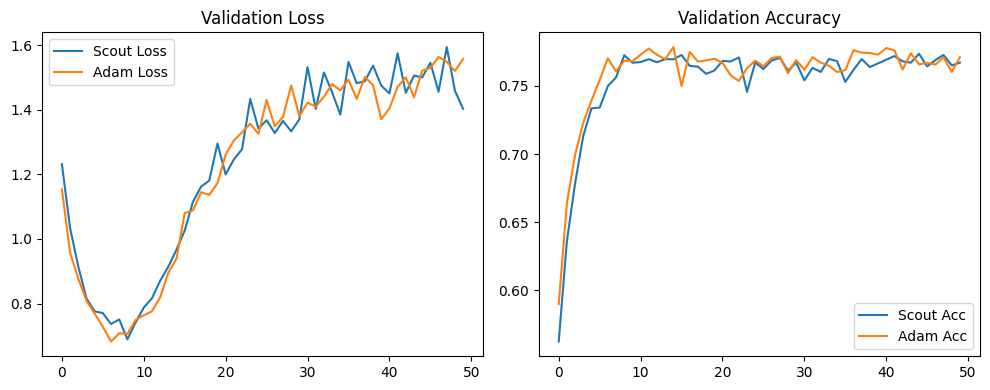

In [5]:
"""scout_opt_cifar10.py

Quick‑and‑dirty *large(-ish)* demo of the scout–guided optimizer on CIFAR‑10.

• Dataset  : CIFAR‑10 (50 k train / 10 k test, 32×32 colour)
• Model    : lightweight CNN (~0.6 M params)
• Baseline : Adam
• ScoutOpt : wraps Adam, periodically probes 2 directions
             (current grad + one random orthogonal) with
             a 1‑step look‑ahead on the same mini‑batch.

Run from a Jupyter cell (accepts the stray -f arg) or from CLI:
    python scout_opt_cifar10.py --gpu  
-------------------------------------------------------"""

import argparse, time, pathlib, random, sys
from typing import List

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# ------------------------------------------------------------------ #
#  1. A small-ish CNN                                                #
# ------------------------------------------------------------------ #
class SmallCNN(nn.Module):
    def __init__(self, n_classes: int = 10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.fc1   = nn.Linear(256 * 4 * 4, 256)
        self.fc2   = nn.Linear(256, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32→16
        x = self.pool(F.relu(self.conv2(x)))  # 16→8
        x = self.pool(F.relu(self.conv3(x)))  # 8 →4
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# ------------------------------------------------------------------ #
#  2. Scout‑guided Optimizer                                         #
# ------------------------------------------------------------------ #
class ScoutOptimizer(optim.Optimizer):
    """Light wrapper that adds a cheap 1‑step look‑ahead probe."""

    def __init__(self, params, base_opt_cls, *, lr=3e-4, scout_every=100, scout_radius=5e-4, **base_kwargs):
        param_list = list(params)
        self.base = base_opt_cls(param_list, lr=lr, **base_kwargs)
        super().__init__(param_list, defaults=dict(lr=lr))
        self.s_every  = scout_every
        self.radius   = scout_radius
        self._step_id = 0
        self._params  = param_list

    @staticmethod
    @torch.no_grad()
    def _flatten(tensors: List[torch.Tensor]):
        return torch.cat([t.reshape(-1) for t in tensors])

    @torch.no_grad()
    def _apply_delta(self, vec_flat: torch.Tensor, coef: float):
        offset = 0
        for p in self._params:
            n = p.numel()
            p.add_(vec_flat[offset:offset+n].view_as(p), alpha=coef)
            offset += n

    @staticmethod
    @torch.no_grad()
    def _rand_orthogonal(base: torch.Tensor):
        r = torch.randn_like(base)
        proj = (r @ base) / (base @ base + 1e-12)
        ortho = r - proj * base
        return ortho / (ortho.norm() + 1e-12)

    def step(self, closure=None):
        if closure is None:
            raise RuntimeError("ScoutOptimizer needs a closure that returns loss and does backward()")

        loss = closure()
        self._step_id += 1

        if self._step_id % self.s_every == 0:
            grad_flat = self._flatten([p.grad for p in self._params])
            grad_norm = grad_flat.norm() + 1e-12
            grad_dir  = grad_flat / grad_norm
            dirs = [grad_dir, self._rand_orthogonal(grad_dir)]

            best_dir, best_loss = None, loss.item()
            for d in dirs:
                self._apply_delta(d, +self.radius)
                probe_loss = closure()
                self._apply_delta(d, -self.radius)
                if probe_loss < best_loss:
                    best_loss = probe_loss
                    best_dir  = d
            if best_dir is not None:
                new_grad = best_dir * grad_norm
                offset = 0
                for p in self._params:
                    n = p.numel()
                    p.grad.copy_(new_grad[offset:offset+n].view_as(p))
                    offset += n

        self.base.step()
        return loss

# ------------------------------------------------------------------ #
#  3. Training / evaluation loops                                    #
# ------------------------------------------------------------------ #
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    tot_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        tot_loss += criterion(out, y).item() * x.size(0)
        pred = out.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return tot_loss / total, correct / total


def train_one_epoch(model, loader, criterion, opt, device, log_every=100):
    model.train()
    running = 0.0
    for i, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        def closure():
            opt.base.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            return loss
        loss = opt.step(closure)
        running += loss.item()
        if (i + 1) % log_every == 0:
            print(f"  batch {i+1}/{len(loader)}  loss {running/log_every:.3f}")
            running = 0.0


# ------------------------------------------------------------------ #
#  4. Baseline Adam Check                                                     #
# ------------------------------------------------------------------ #


def run_baseline_adam(epochs=6, batch=128, lr=3e-4, results=None):
    print("\nBaseline: Adam")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))
    ])
    root = str(pathlib.Path.home() / ".torchdata")
    train_set = datasets.CIFAR10(root=root, train=True,  download=True, transform=transform)
    test_set  = datasets.CIFAR10(root=root, train=False, download=True, transform=transform)
    train_loader = DataLoader(train_set, batch_size=batch, shuffle=True,  num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_set,  batch_size=256,   shuffle=False, num_workers=2, pin_memory=True)

    model = SmallCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=1e-4)

    for ep in range(1, epochs+1):
        print(f"\nEpoch {ep}/{epochs}")
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

        val_loss, val_acc = evaluate(model, test_loader, criterion, device)
        print(f"  val_loss={val_loss:.3f}  val_acc={val_acc:.3f}")
        if results is not None:
            results['adam_loss'].append(val_loss)
            results['adam_acc'].append(val_acc)

# ------------------------------------------------------------------ #
#  5. Main                                                           #
# ------------------------------------------------------------------ #


def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('--epochs', type=int, default=50)
    parser.add_argument('--batch',  type=int, default=128)
    parser.add_argument('--lr',     type=float, default=3e-4)
    parser.add_argument('--scout_every',  type=int, default=100)
    parser.add_argument('--scout_radius', type=float, default=5e-4)
    parser.add_argument('--gpu', action='store_true')
    args, _ = parser.parse_known_args()

    device = torch.device('cuda' if args.gpu and torch.cuda.is_available() else 'cpu')
    print('Device:', device)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))
    ])

    root = str(pathlib.Path.home() / ".torchdata")
    train_set = datasets.CIFAR10(root=root, train=True,  download=True, transform=transform)
    test_set  = datasets.CIFAR10(root=root, train=False, download=True, transform=transform)

    train_loader = DataLoader(train_set, batch_size=args.batch, shuffle=True,  num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_set,  batch_size=256,       shuffle=False, num_workers=2, pin_memory=True)

    model = SmallCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    opt = ScoutOptimizer(model.parameters(), optim.Adam,
                         lr=args.lr,
                         scout_every=args.scout_every,
                         scout_radius=args.scout_radius,
                         betas=(0.9, 0.999), weight_decay=1e-4)

    results = {'scout_loss': [], 'scout_acc': [], 'adam_loss': [], 'adam_acc': []}

    for ep in range(1, args.epochs+1):
        print(f"\nEpoch {ep}/{args.epochs}")
        start = time.time()
        train_one_epoch(model, train_loader, criterion, opt, device)
        val_loss, val_acc = evaluate(model, test_loader, criterion, device)
        print(f"  val_loss={val_loss:.3f}  val_acc={val_acc:.3f}  ({time.time() - start:.1f}s)")
        results['scout_loss'].append(val_loss)
        results['scout_acc'].append(val_acc)

    torch.save(model.state_dict(), "scout_cnn.pth")
    print("Model saved to scout_cnn.pth")

    run_baseline_adam(epochs=args.epochs, batch=args.batch, lr=args.lr, results=results)

    print("\nFinal comparison table:")
    for i in range(args.epochs):
        print(f"Epoch {i+1:>2}:  Scout acc = {results['scout_acc'][i]*100:.2f}%  |  Adam acc = {results['adam_acc'][i]*100:.2f}%")

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(results['scout_loss'], label='Scout Loss')
    plt.plot(results['adam_loss'],  label='Adam Loss')
    plt.legend()
    plt.title("Validation Loss")

    plt.subplot(1, 2, 2)
    plt.plot(results['scout_acc'], label='Scout Acc')
    plt.plot(results['adam_acc'],  label='Adam Acc')
    plt.legend()
    plt.title("Validation Accuracy")
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    if sys.argv[0].endswith("ipykernel_launcher.py"):
        sys.argv = ['scout_opt_cifar10.py']
    main()


sys.argv: ['scout_opt_cifar10.py', '--gpu']
args.gpu: True
Device: cuda
Files already downloaded and verified
Files already downloaded and verified

Epoch 1/50
  batch 100/391  loss 1.796
  batch 200/391  loss 1.444
  batch 300/391  loss 1.313
  val_loss=1.154  val_acc=0.595  (19.6s)

Epoch 2/50
  batch 100/391  loss 1.098
  batch 200/391  loss 1.066
  batch 300/391  loss 0.999
  val_loss=0.962  val_acc=0.664  (17.9s)

Epoch 3/50
  batch 100/391  loss 0.901
  batch 200/391  loss 0.876
  batch 300/391  loss 0.843
  val_loss=0.881  val_acc=0.696  (18.3s)

Epoch 4/50
  batch 100/391  loss 0.773
  batch 200/391  loss 0.744
  batch 300/391  loss 0.750
  val_loss=0.790  val_acc=0.730  (17.9s)

Epoch 5/50
  batch 100/391  loss 0.650
  batch 200/391  loss 0.664
  batch 300/391  loss 0.671
  val_loss=0.784  val_acc=0.732  (18.7s)

Epoch 6/50
  batch 100/391  loss 0.579
  batch 200/391  loss 0.588
  batch 300/391  loss 0.570
  val_loss=0.767  val_acc=0.737  (18.7s)

Epoch 7/50
  batch 100/391  l

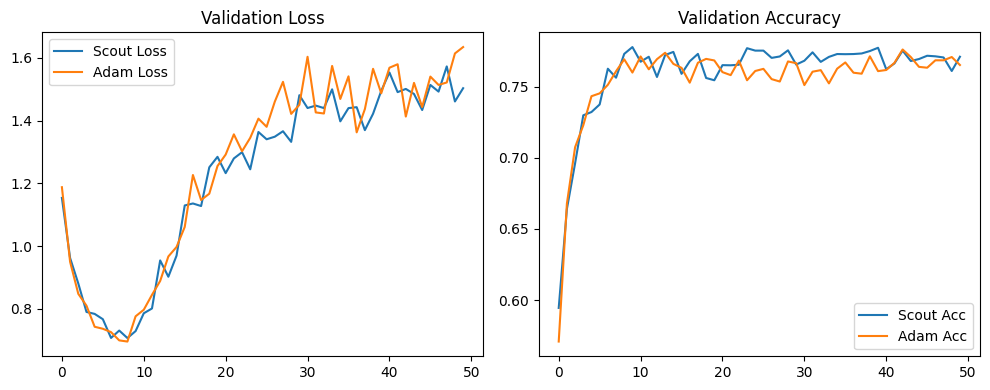

In [10]:
"""scout_opt_cifar10.py

Quick‑and‑dirty *large(-ish)* demo of the scout–guided optimizer on CIFAR‑10.

• Dataset  : CIFAR‑10 (50 k train / 10 k test, 32×32 colour)
• Model    : lightweight CNN (~0.6 M params)
• Baseline : Adam
• ScoutOpt : wraps Adam, periodically probes 2 directions
             (current grad + one random orthogonal) with
             a 1‑step look‑ahead on the same mini‑batch.

Run from a Jupyter cell (accepts the stray -f arg) or from CLI:
    python scout_opt_cifar10.py --gpu  
-------------------------------------------------------"""

import argparse, time, pathlib, random, sys
from typing import List

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# ------------------------------------------------------------------ #
#  1. A small-ish CNN                                                #
# ------------------------------------------------------------------ #
class SmallCNN(nn.Module):
    def __init__(self, n_classes: int = 10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.fc1   = nn.Linear(256 * 4 * 4, 256)
        self.fc2   = nn.Linear(256, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32→16
        x = self.pool(F.relu(self.conv2(x)))  # 16→8
        x = self.pool(F.relu(self.conv3(x)))  # 8 →4
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# ------------------------------------------------------------------ #
#  2. Scout‑guided Optimizer                                         #
# ------------------------------------------------------------------ #
class ScoutOptimizer(optim.Optimizer):
    """Light wrapper that adds a cheap 1‑step look‑ahead probe."""

    def __init__(self, params, base_opt_cls, *, lr=3e-4, scout_every=100, scout_radius=5e-4, **base_kwargs):
        param_list = list(params)
        self.base = base_opt_cls(param_list, lr=lr, **base_kwargs)
        super().__init__(param_list, defaults=dict(lr=lr))
        self.s_every  = scout_every
        self.radius   = scout_radius
        self._step_id = 0
        self._params  = param_list

    @staticmethod
    @torch.no_grad()
    def _flatten(tensors: List[torch.Tensor]):
        return torch.cat([t.reshape(-1) for t in tensors])

    @torch.no_grad()
    def _apply_delta(self, vec_flat: torch.Tensor, coef: float):
        offset = 0
        for p in self._params:
            n = p.numel()
            p.add_(vec_flat[offset:offset+n].view_as(p), alpha=coef)
            offset += n

    @staticmethod
    @torch.no_grad()
    def _rand_orthogonal(base: torch.Tensor):
        r = torch.randn_like(base)
        proj = (r @ base) / (base @ base + 1e-12)
        ortho = r - proj * base
        return ortho / (ortho.norm() + 1e-12)

    def step(self, closure=None):
        if closure is None:
            raise RuntimeError("ScoutOptimizer needs a closure that returns loss and does backward()")

        loss = closure()
        self._step_id += 1

        if self._step_id % self.s_every == 0:
            grad_flat = self._flatten([p.grad for p in self._params])
            grad_norm = grad_flat.norm() + 1e-12
            grad_dir  = grad_flat / grad_norm
            dirs = [grad_dir, self._rand_orthogonal(grad_dir)]

            best_dir, best_loss = None, loss.item()
            for d in dirs:
                self._apply_delta(d, +self.radius)
                probe_loss = closure()
                self._apply_delta(d, -self.radius)
                if probe_loss < best_loss:
                    best_loss = probe_loss
                    best_dir  = d
            if best_dir is not None:
                new_grad = best_dir * grad_norm
                offset = 0
                for p in self._params:
                    n = p.numel()
                    p.grad.copy_(new_grad[offset:offset+n].view_as(p))
                    offset += n

        self.base.step()
        return loss

# ------------------------------------------------------------------ #
#  3. Training / evaluation loops                                    #
# ------------------------------------------------------------------ #
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    tot_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        tot_loss += criterion(out, y).item() * x.size(0)
        pred = out.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return tot_loss / total, correct / total


def train_one_epoch(model, loader, criterion, opt, device, log_every=100):
    model.train()
    running = 0.0
    for i, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        def closure():
            opt.base.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            return loss
        loss = opt.step(closure)
        running += loss.item()
        if (i + 1) % log_every == 0:
            print(f"  batch {i+1}/{len(loader)}  loss {running/log_every:.3f}")
            running = 0.0


# ------------------------------------------------------------------ #
#  4. Baseline Adam Check                                                     #
# ------------------------------------------------------------------ #


def run_baseline_adam(epochs=6, batch=128, lr=3e-4, results=None):
    print("\nBaseline: Adam")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))
    ])
    root = str(pathlib.Path.home() / ".torchdata")
    train_set = datasets.CIFAR10(root=root, train=True,  download=True, transform=transform)
    test_set  = datasets.CIFAR10(root=root, train=False, download=True, transform=transform)
    train_loader = DataLoader(train_set, batch_size=batch, shuffle=True,  num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_set,  batch_size=256,   shuffle=False, num_workers=2, pin_memory=True)

    model = SmallCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=1e-4)

    for ep in range(1, epochs+1):
        print(f"\nEpoch {ep}/{epochs}")
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

        val_loss, val_acc = evaluate(model, test_loader, criterion, device)
        print(f"  val_loss={val_loss:.3f}  val_acc={val_acc:.3f}")
        if results is not None:
            results['adam_loss'].append(val_loss)
            results['adam_acc'].append(val_acc)

# ------------------------------------------------------------------ #
#  5. Main                                                           #
# ------------------------------------------------------------------ #

def main():
    # ✅ Fix: Inject --gpu before parsing arguments if running inside Jupyter

    if '--gpu' not in sys.argv and '--cpu' not in sys.argv:
        sys.argv += ['--gpu']

    parser = argparse.ArgumentParser()
    parser.add_argument('--epochs', type=int, default=50)
    parser.add_argument('--batch',  type=int, default=128)
    parser.add_argument('--lr',     type=float, default=3e-4)
    parser.add_argument('--scout_every',  type=int, default=100)
    parser.add_argument('--scout_radius', type=float, default=5e-4)
    parser.add_argument('--gpu', action='store_true')
    args, _ = parser.parse_known_args()

    device = torch.device('cuda' if args.gpu and torch.cuda.is_available() else 'cpu')
    print("sys.argv:", sys.argv)
    print("args.gpu:", args.gpu)
    print("Device:", device)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))
    ])

    root = str(pathlib.Path.home() / ".torchdata")
    train_set = datasets.CIFAR10(root=root, train=True,  download=True, transform=transform)
    test_set  = datasets.CIFAR10(root=root, train=False, download=True, transform=transform)

    train_loader = DataLoader(train_set, batch_size=args.batch, shuffle=True,  num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_set,  batch_size=256,       shuffle=False, num_workers=2, pin_memory=True)

    model = SmallCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    opt = ScoutOptimizer(model.parameters(), optim.Adam,
                         lr=args.lr,
                         scout_every=args.scout_every,
                         scout_radius=args.scout_radius,
                         betas=(0.9, 0.999), weight_decay=1e-4)

    results = {'scout_loss': [], 'scout_acc': [], 'adam_loss': [], 'adam_acc': []}

    for ep in range(1, args.epochs+1):
        print(f"\nEpoch {ep}/{args.epochs}")
        start = time.time()
        train_one_epoch(model, train_loader, criterion, opt, device)
        val_loss, val_acc = evaluate(model, test_loader, criterion, device)
        print(f"  val_loss={val_loss:.3f}  val_acc={val_acc:.3f}  ({time.time() - start:.1f}s)")
        results['scout_loss'].append(val_loss)
        results['scout_acc'].append(val_acc)

    torch.save(model.state_dict(), "scout_cnn.pth")
    print("Model saved to scout_cnn.pth")

    run_baseline_adam(epochs=args.epochs, batch=args.batch, lr=args.lr, results=results)

    print("\nFinal comparison table:")
    for i in range(args.epochs):
        print(f"Epoch {i+1:>2}:  Scout acc = {results['scout_acc'][i]*100:.2f}%  |  Adam acc = {results['adam_acc'][i]*100:.2f}%")

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(results['scout_loss'], label='Scout Loss')
    plt.plot(results['adam_loss'],  label='Adam Loss')
    plt.legend()
    plt.title("Validation Loss")

    plt.subplot(1, 2, 2)
    plt.plot(results['scout_acc'], label='Scout Acc')
    plt.plot(results['adam_acc'],  label='Adam Acc')
    plt.legend()
    plt.title("Validation Accuracy")
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()



sys.argv: ['scout_opt_cifar10.py', '--gpu']
args.gpu: True
Device: cuda
Files already downloaded and verified
Files already downloaded and verified

Epoch 1/50
  batch 100/391  loss 1.784
  batch 200/391  loss 1.452
  batch 300/391  loss 1.326
  val_loss=1.172  val_acc=0.577  (17.7s)

Epoch 2/50
  batch 100/391  loss 1.107
  batch 200/391  loss 1.068
  batch 300/391  loss 1.003
  val_loss=0.947  val_acc=0.666  (17.7s)

Epoch 3/50
  batch 100/391  loss 0.905
  batch 200/391  loss 0.874
  batch 300/391  loss 0.857
  val_loss=0.874  val_acc=0.696  (17.8s)

Epoch 4/50
  batch 100/391  loss 0.760
  batch 200/391  loss 0.756
  batch 300/391  loss 0.751
  val_loss=0.790  val_acc=0.729  (17.8s)

Epoch 5/50
  batch 100/391  loss 0.669
  batch 200/391  loss 0.656
  batch 300/391  loss 0.663
  val_loss=0.799  val_acc=0.727  (17.3s)

Epoch 6/50
  batch 100/391  loss 0.580
  batch 200/391  loss 0.568
  batch 300/391  loss 0.586
  val_loss=0.728  val_acc=0.754  (17.5s)

Epoch 7/50
  batch 100/391  l

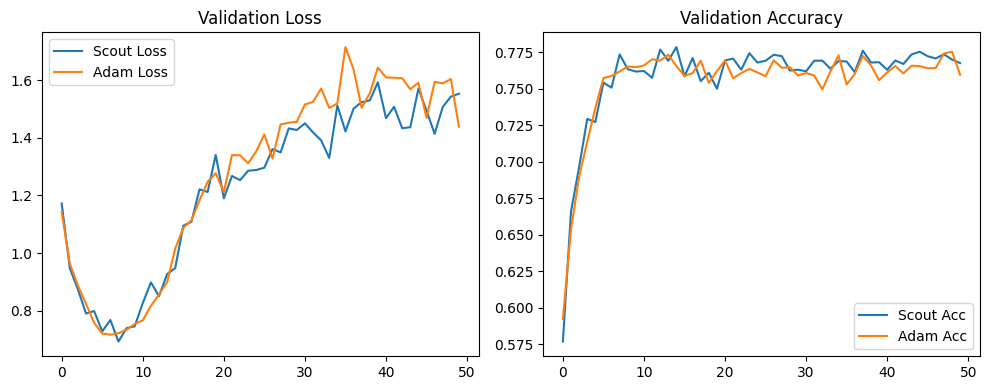

In [11]:
"""scout_opt_cifar10.py

Quick‑and‑dirty *large(-ish)* demo of the scout–guided optimizer on CIFAR‑10.

• Dataset  : CIFAR‑10 (50 k train / 10 k test, 32×32 colour)
• Model    : lightweight CNN (~0.6 M params)
• Baseline : Adam
• ScoutOpt : wraps Adam, periodically probes 2 directions
             (current grad + one random orthogonal) with
             a 1‑step look‑ahead on the same mini‑batch.

Run from a Jupyter cell (accepts the stray -f arg) or from CLI:
    python scout_opt_cifar10.py --gpu  
-------------------------------------------------------"""

import argparse, time, pathlib, random, sys
from typing import List

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# ------------------------------------------------------------------ #
#  1. A small-ish CNN                                                #
# ------------------------------------------------------------------ #
class SmallCNN(nn.Module):
    def __init__(self, n_classes: int = 10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.fc1   = nn.Linear(256 * 4 * 4, 256)
        self.fc2   = nn.Linear(256, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32→16
        x = self.pool(F.relu(self.conv2(x)))  # 16→8
        x = self.pool(F.relu(self.conv3(x)))  # 8 →4
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# ------------------------------------------------------------------ #
#  2. Scout‑guided Optimizer                                         #
# ------------------------------------------------------------------ #
class ScoutOptimizer(optim.Optimizer):
    """Light wrapper that adds a cheap 1‑step look‑ahead probe."""

    def __init__(self, params, base_opt_cls, *, lr=3e-4, scout_every=100, scout_radius=5e-4, **base_kwargs):
        param_list = list(params)
        self.base = base_opt_cls(param_list, lr=lr, **base_kwargs)
        super().__init__(param_list, defaults=dict(lr=lr))
        self.s_every  = scout_every
        self.radius   = scout_radius
        self._step_id = 0
        self._params  = param_list

    @staticmethod
    @torch.no_grad()
    def _flatten(tensors: List[torch.Tensor]):
        return torch.cat([t.reshape(-1) for t in tensors])

    @torch.no_grad()
    def _apply_delta(self, vec_flat: torch.Tensor, coef: float):
        offset = 0
        for p in self._params:
            n = p.numel()
            p.add_(vec_flat[offset:offset+n].view_as(p), alpha=coef)
            offset += n

    @staticmethod
    @torch.no_grad()
    def _rand_orthogonal(base: torch.Tensor):
        r = torch.randn_like(base)
        proj = (r @ base) / (base @ base + 1e-12)
        ortho = r - proj * base
        return ortho / (ortho.norm() + 1e-12)

    def step(self, closure=None):
        if closure is None:
            raise RuntimeError("ScoutOptimizer needs a closure that returns loss and does backward()")

        loss = closure()
        self._step_id += 1

        if self._step_id % self.s_every == 0:
            grad_flat = self._flatten([p.grad for p in self._params])
            grad_norm = grad_flat.norm() + 1e-12
            grad_dir  = grad_flat / grad_norm
            dirs = [grad_dir, self._rand_orthogonal(grad_dir)]

            best_dir, best_loss = None, loss.item()
            for d in dirs:
                self._apply_delta(d, +self.radius)
                probe_loss = closure()
                self._apply_delta(d, -self.radius)
                if probe_loss < best_loss:
                    best_loss = probe_loss
                    best_dir  = d
            if best_dir is not None:
                new_grad = best_dir * grad_norm
                offset = 0
                for p in self._params:
                    n = p.numel()
                    p.grad.copy_(new_grad[offset:offset+n].view_as(p))
                    offset += n

        self.base.step()
        return loss

# ------------------------------------------------------------------ #
#  3. Training / evaluation loops                                    #
# ------------------------------------------------------------------ #
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    tot_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        tot_loss += criterion(out, y).item() * x.size(0)
        pred = out.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return tot_loss / total, correct / total


def train_one_epoch(model, loader, criterion, opt, device, log_every=100):
    model.train()
    running = 0.0
    for i, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        def closure():
            opt.base.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            return loss
        loss = opt.step(closure)
        running += loss.item()
        if (i + 1) % log_every == 0:
            print(f"  batch {i+1}/{len(loader)}  loss {running/log_every:.3f}")
            running = 0.0


# ------------------------------------------------------------------ #
#  4. Baseline Adam Check                                                     #
# ------------------------------------------------------------------ #


def run_baseline_adam(epochs=6, batch=128, lr=3e-4, results=None):
    print("\nBaseline: Adam")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))
    ])
    root = str(pathlib.Path.home() / ".torchdata")
    train_set = datasets.CIFAR10(root=root, train=True,  download=True, transform=transform)
    test_set  = datasets.CIFAR10(root=root, train=False, download=True, transform=transform)
    train_loader = DataLoader(train_set, batch_size=batch, shuffle=True,  num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_set,  batch_size=256,   shuffle=False, num_workers=2, pin_memory=True)

    model = SmallCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=1e-4)

    for ep in range(1, epochs+1):
        print(f"\nEpoch {ep}/{epochs}")
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

        val_loss, val_acc = evaluate(model, test_loader, criterion, device)
        print(f"  val_loss={val_loss:.3f}  val_acc={val_acc:.3f}")
        if results is not None:
            results['adam_loss'].append(val_loss)
            results['adam_acc'].append(val_acc)

# ------------------------------------------------------------------ #
#  5. Main                                                           #
# ------------------------------------------------------------------ #

def main():
    # ✅ Fix: Inject --gpu before parsing arguments if running inside Jupyter

    if '--gpu' not in sys.argv and '--cpu' not in sys.argv:
        sys.argv += ['--gpu']

    parser = argparse.ArgumentParser()
    parser.add_argument('--epochs', type=int, default=50)
    parser.add_argument('--batch',  type=int, default=128)
    parser.add_argument('--lr',     type=float, default=3e-4)
    parser.add_argument('--scout_every',  type=int, default=100)
    parser.add_argument('--scout_radius', type=float, default=5e-4)
    parser.add_argument('--gpu', action='store_true')
    args, _ = parser.parse_known_args()

    device = torch.device('cuda' if args.gpu and torch.cuda.is_available() else 'cpu')
    print("sys.argv:", sys.argv)
    print("args.gpu:", args.gpu)
    print("Device:", device)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))
    ])

    root = str(pathlib.Path.home() / ".torchdata")
    train_set = datasets.CIFAR10(root=root, train=True,  download=True, transform=transform)
    test_set  = datasets.CIFAR10(root=root, train=False, download=True, transform=transform)

    train_loader = DataLoader(train_set, batch_size=args.batch, shuffle=True,  num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_set,  batch_size=256,       shuffle=False, num_workers=2, pin_memory=True)

    model = SmallCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    opt = ScoutOptimizer(model.parameters(), optim.Adam,
                         lr=args.lr,
                         scout_every=args.scout_every,
                         scout_radius=args.scout_radius,
                         betas=(0.9, 0.999), weight_decay=1e-4)

    results = {'scout_loss': [], 'scout_acc': [], 'adam_loss': [], 'adam_acc': []}

    for ep in range(1, args.epochs+1):
        print(f"\nEpoch {ep}/{args.epochs}")
        start = time.time()
        train_one_epoch(model, train_loader, criterion, opt, device)
        val_loss, val_acc = evaluate(model, test_loader, criterion, device)
        print(f"  val_loss={val_loss:.3f}  val_acc={val_acc:.3f}  ({time.time() - start:.1f}s)")
        results['scout_loss'].append(val_loss)
        results['scout_acc'].append(val_acc)

    torch.save(model.state_dict(), "scout_cnn.pth")
    print("Model saved to scout_cnn.pth")

    run_baseline_adam(epochs=args.epochs, batch=args.batch, lr=args.lr, results=results)

    print("\nFinal comparison table:")
    for i in range(args.epochs):
        print(f"Epoch {i+1:>2}:  Scout acc = {results['scout_acc'][i]*100:.2f}%  |  Adam acc = {results['adam_acc'][i]*100:.2f}%")

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(results['scout_loss'], label='Scout Loss')
    plt.plot(results['adam_loss'],  label='Adam Loss')
    plt.legend()
    plt.title("Validation Loss")

    plt.subplot(1, 2, 2)
    plt.plot(results['scout_acc'], label='Scout Acc')
    plt.plot(results['adam_acc'],  label='Adam Acc')
    plt.legend()
    plt.title("Validation Accuracy")
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()



sys.argv: ['scout_opt_cifar10.py', '--gpu']
args.gpu: True
Device: cuda
Files already downloaded and verified
Files already downloaded and verified

Epoch 1/50
  batch 100/391  loss 1.808
  batch 200/391  loss 1.464
  batch 300/391  loss 1.319
  val_loss=1.221  val_acc=0.557  (16.2s)

Epoch 2/50
  batch 100/391  loss 1.120
  batch 200/391  loss 1.092
  batch 300/391  loss 1.021
  val_loss=0.967  val_acc=0.656  (16.4s)

Epoch 3/50
  batch 100/391  loss 0.900
  batch 200/391  loss 0.890
  batch 300/391  loss 0.859
  val_loss=0.888  val_acc=0.691  (16.1s)

Epoch 4/50
  batch 100/391  loss 0.763
  batch 200/391  loss 0.787
  batch 300/391  loss 0.741
  val_loss=0.803  val_acc=0.719  (16.3s)

Epoch 5/50
  batch 100/391  loss 0.662
  batch 200/391  loss 0.669
  batch 300/391  loss 0.675
  val_loss=0.752  val_acc=0.742  (16.2s)

Epoch 6/50
  batch 100/391  loss 0.591
  batch 200/391  loss 0.583
  batch 300/391  loss 0.588
  val_loss=0.738  val_acc=0.745  (16.1s)

Epoch 7/50
  batch 100/391  l

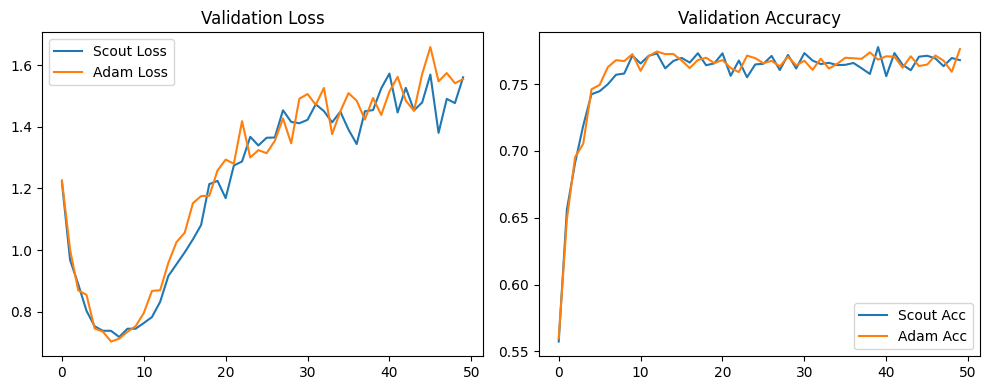

In [12]:
"""scout_opt_cifar10.py

Quick‑and‑dirty *large(-ish)* demo of the scout–guided optimizer on CIFAR‑10.

• Dataset  : CIFAR‑10 (50 k train / 10 k test, 32×32 colour)
• Model    : lightweight CNN (~0.6 M params)
• Baseline : Adam
• ScoutOpt : wraps Adam, periodically probes 2 directions
             (current grad + one random orthogonal) with
             a 1‑step look‑ahead on the same mini‑batch.

Run from a Jupyter cell (accepts the stray -f arg) or from CLI:
    python scout_opt_cifar10.py --gpu  
-------------------------------------------------------"""

import argparse, time, pathlib, random, sys
from typing import List

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# ------------------------------------------------------------------ #
#  1. A small-ish CNN                                                #
# ------------------------------------------------------------------ #
class SmallCNN(nn.Module):
    def __init__(self, n_classes: int = 10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.fc1   = nn.Linear(256 * 4 * 4, 256)
        self.fc2   = nn.Linear(256, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32→16
        x = self.pool(F.relu(self.conv2(x)))  # 16→8
        x = self.pool(F.relu(self.conv3(x)))  # 8 →4
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# ------------------------------------------------------------------ #
#  2. Scout‑guided Optimizer                                         #
# ------------------------------------------------------------------ #
class ScoutOptimizer(optim.Optimizer):
    """Light wrapper that adds a cheap 1‑step look‑ahead probe."""

    def __init__(self, params, base_opt_cls, *, lr=3e-4, scout_every=100, scout_radius=5e-4, **base_kwargs):
        param_list = list(params)
        self.base = base_opt_cls(param_list, lr=lr, **base_kwargs)
        super().__init__(param_list, defaults=dict(lr=lr))
        self.s_every  = scout_every
        self.radius   = scout_radius
        self._step_id = 0
        self._params  = param_list

    @staticmethod
    @torch.no_grad()
    def _flatten(tensors: List[torch.Tensor]):
        return torch.cat([t.reshape(-1) for t in tensors])

    @torch.no_grad()
    def _apply_delta(self, vec_flat: torch.Tensor, coef: float):
        offset = 0
        for p in self._params:
            n = p.numel()
            p.add_(vec_flat[offset:offset+n].view_as(p), alpha=coef)
            offset += n

    @staticmethod
    @torch.no_grad()
    def _rand_orthogonal(base: torch.Tensor):
        r = torch.randn_like(base)
        proj = (r @ base) / (base @ base + 1e-12)
        ortho = r - proj * base
        return ortho / (ortho.norm() + 1e-12)

    def step(self, closure=None):
        if closure is None:
            raise RuntimeError("ScoutOptimizer needs a closure that returns loss and does backward()")

        loss = closure()
        self._step_id += 1

        if self._step_id % self.s_every == 0:
            grad_flat = self._flatten([p.grad for p in self._params])
            grad_norm = grad_flat.norm() + 1e-12
            grad_dir  = grad_flat / grad_norm
            dirs = [grad_dir, self._rand_orthogonal(grad_dir)]

            best_dir, best_loss = None, loss.item()
            for d in dirs:
                self._apply_delta(d, +self.radius)
                probe_loss = closure()
                self._apply_delta(d, -self.radius)
                if probe_loss < best_loss:
                    best_loss = probe_loss
                    best_dir  = d
            if best_dir is not None:
                new_grad = best_dir * grad_norm
                offset = 0
                for p in self._params:
                    n = p.numel()
                    p.grad.copy_(new_grad[offset:offset+n].view_as(p))
                    offset += n

        self.base.step()
        return loss

# ------------------------------------------------------------------ #
#  3. Training / evaluation loops                                    #
# ------------------------------------------------------------------ #
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    tot_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        tot_loss += criterion(out, y).item() * x.size(0)
        pred = out.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return tot_loss / total, correct / total


def train_one_epoch(model, loader, criterion, opt, device, log_every=100):
    model.train()
    running = 0.0
    for i, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        def closure():
            opt.base.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            return loss
        loss = opt.step(closure)
        running += loss.item()
        if (i + 1) % log_every == 0:
            print(f"  batch {i+1}/{len(loader)}  loss {running/log_every:.3f}")
            running = 0.0


# ------------------------------------------------------------------ #
#  4. Baseline Adam Check                                                     #
# ------------------------------------------------------------------ #


def run_baseline_adam(epochs=6, batch=128, lr=3e-4, results=None):
    print("\nBaseline: Adam")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))
    ])
    root = str(pathlib.Path.home() / ".torchdata")
    train_set = datasets.CIFAR10(root=root, train=True,  download=True, transform=transform)
    test_set  = datasets.CIFAR10(root=root, train=False, download=True, transform=transform)
    train_loader = DataLoader(train_set, batch_size=batch, shuffle=True,  num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_set,  batch_size=256,   shuffle=False, num_workers=2, pin_memory=True)

    model = SmallCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=1e-4)

    for ep in range(1, epochs+1):
        print(f"\nEpoch {ep}/{epochs}")
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

        val_loss, val_acc = evaluate(model, test_loader, criterion, device)
        print(f"  val_loss={val_loss:.3f}  val_acc={val_acc:.3f}")
        if results is not None:
            results['adam_loss'].append(val_loss)
            results['adam_acc'].append(val_acc)

# ------------------------------------------------------------------ #
#  5. Main                                                           #
# ------------------------------------------------------------------ #

def main():
    # ✅ Fix: Inject --gpu before parsing arguments if running inside Jupyter

    if '--gpu' not in sys.argv and '--cpu' not in sys.argv:
        sys.argv += ['--gpu']

    parser = argparse.ArgumentParser()
    parser.add_argument('--epochs', type=int, default=50)
    parser.add_argument('--batch',  type=int, default=128)
    parser.add_argument('--lr',     type=float, default=3e-4)
    parser.add_argument('--scout_every',  type=int, default=100)
    parser.add_argument('--scout_radius', type=float, default=5e-4)
    parser.add_argument('--gpu', action='store_true')
    args, _ = parser.parse_known_args()

    device = torch.device('cuda' if args.gpu and torch.cuda.is_available() else 'cpu')
    print("sys.argv:", sys.argv)
    print("args.gpu:", args.gpu)
    print("Device:", device)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))
    ])

    root = str(pathlib.Path.home() / ".torchdata")
    train_set = datasets.CIFAR10(root=root, train=True,  download=True, transform=transform)
    test_set  = datasets.CIFAR10(root=root, train=False, download=True, transform=transform)

    train_loader = DataLoader(train_set, batch_size=args.batch, shuffle=True,  num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_set,  batch_size=256,       shuffle=False, num_workers=2, pin_memory=True)

    model = SmallCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    opt = ScoutOptimizer(model.parameters(), optim.Adam,
                         lr=args.lr,
                         scout_every=args.scout_every,
                         scout_radius=args.scout_radius,
                         betas=(0.9, 0.999), weight_decay=1e-4)

    results = {'scout_loss': [], 'scout_acc': [], 'adam_loss': [], 'adam_acc': []}

    for ep in range(1, args.epochs+1):
        print(f"\nEpoch {ep}/{args.epochs}")
        start = time.time()
        train_one_epoch(model, train_loader, criterion, opt, device)
        val_loss, val_acc = evaluate(model, test_loader, criterion, device)
        print(f"  val_loss={val_loss:.3f}  val_acc={val_acc:.3f}  ({time.time() - start:.1f}s)")
        results['scout_loss'].append(val_loss)
        results['scout_acc'].append(val_acc)

    torch.save(model.state_dict(), "scout_cnn.pth")
    print("Model saved to scout_cnn.pth")

    run_baseline_adam(epochs=args.epochs, batch=args.batch, lr=args.lr, results=results)

    print("\nFinal comparison table:")
    for i in range(args.epochs):
        print(f"Epoch {i+1:>2}:  Scout acc = {results['scout_acc'][i]*100:.2f}%  |  Adam acc = {results['adam_acc'][i]*100:.2f}%")

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(results['scout_loss'], label='Scout Loss')
    plt.plot(results['adam_loss'],  label='Adam Loss')
    plt.legend()
    plt.title("Validation Loss")

    plt.subplot(1, 2, 2)
    plt.plot(results['scout_acc'], label='Scout Acc')
    plt.plot(results['adam_acc'],  label='Adam Acc')
    plt.legend()
    plt.title("Validation Accuracy")
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()



sys.argv: ['scout_opt_cifar10.py', '--gpu']
args.gpu: True
Device: cuda
Files already downloaded and verified
Files already downloaded and verified

Epoch 1/50
  batch 100/391  loss 1.838
  batch 200/391  loss 1.457
  batch 300/391  loss 1.303
  val_loss=1.146  val_acc=0.592  (15.8s)

Epoch 2/50
  batch 100/391  loss 1.137
  batch 200/391  loss 1.072
  batch 300/391  loss 1.016
  val_loss=0.963  val_acc=0.660  (16.1s)

Epoch 3/50
  batch 100/391  loss 0.899
  batch 200/391  loss 0.865
  batch 300/391  loss 0.860
  val_loss=0.851  val_acc=0.706  (15.9s)

Epoch 4/50
  batch 100/391  loss 0.777
  batch 200/391  loss 0.750
  batch 300/391  loss 0.730
  val_loss=0.796  val_acc=0.722  (16.2s)

Epoch 5/50
  batch 100/391  loss 0.644
  batch 200/391  loss 0.647
  batch 300/391  loss 0.651
  val_loss=0.740  val_acc=0.744  (16.2s)

Epoch 6/50
  batch 100/391  loss 0.566
  batch 200/391  loss 0.556
  batch 300/391  loss 0.553
  val_loss=0.761  val_acc=0.744  (16.1s)

Epoch 7/50
  batch 100/391  l

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000002B4A57394C0>
Traceback (most recent call last):
  File "C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\torch\utils\data\dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\torch\utils\data\dataloader.py", line 1435, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000002B4A57394C0>
Traceback (most recent call last):
  File "C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\torch\utils\data\dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "C:\Users\Machine-Learning\anaconda3\envs\pytorch_env\lib\site-packages\torch\utils\data\dataloader.py", l

  val_loss=1.519  val_acc=0.780

Final comparison table:
Epoch  1:  Scout acc = 59.19%  |  Adam acc = 58.13%
Epoch  2:  Scout acc = 66.00%  |  Adam acc = 66.08%
Epoch  3:  Scout acc = 70.56%  |  Adam acc = 67.53%
Epoch  4:  Scout acc = 72.24%  |  Adam acc = 72.97%
Epoch  5:  Scout acc = 74.39%  |  Adam acc = 74.30%
Epoch  6:  Scout acc = 74.43%  |  Adam acc = 75.08%
Epoch  7:  Scout acc = 76.10%  |  Adam acc = 75.18%
Epoch  8:  Scout acc = 76.74%  |  Adam acc = 75.68%
Epoch  9:  Scout acc = 76.69%  |  Adam acc = 76.76%
Epoch 10:  Scout acc = 77.11%  |  Adam acc = 76.71%
Epoch 11:  Scout acc = 76.75%  |  Adam acc = 77.79%
Epoch 12:  Scout acc = 76.79%  |  Adam acc = 77.27%
Epoch 13:  Scout acc = 76.91%  |  Adam acc = 76.75%
Epoch 14:  Scout acc = 76.43%  |  Adam acc = 77.21%
Epoch 15:  Scout acc = 75.78%  |  Adam acc = 77.86%
Epoch 16:  Scout acc = 76.35%  |  Adam acc = 76.56%
Epoch 17:  Scout acc = 75.27%  |  Adam acc = 76.09%
Epoch 18:  Scout acc = 75.84%  |  Adam acc = 77.20%
Epoch 1

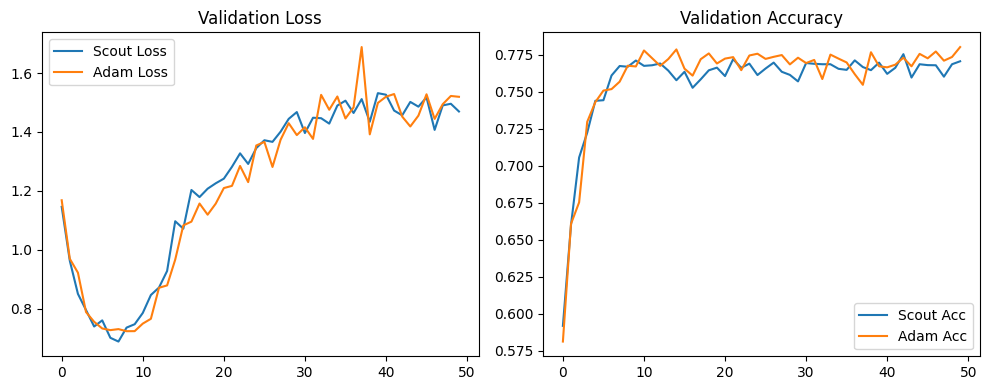

In [13]:
"""scout_opt_cifar10.py

Quick‑and‑dirty *large(-ish)* demo of the scout–guided optimizer on CIFAR‑10.

• Dataset  : CIFAR‑10 (50 k train / 10 k test, 32×32 colour)
• Model    : lightweight CNN (~0.6 M params)
• Baseline : Adam
• ScoutOpt : wraps Adam, periodically probes 2 directions
             (current grad + one random orthogonal) with
             a 1‑step look‑ahead on the same mini‑batch.

Run from a Jupyter cell (accepts the stray -f arg) or from CLI:
    python scout_opt_cifar10.py --gpu  
-------------------------------------------------------"""

import argparse, time, pathlib, random, sys
from typing import List

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# ------------------------------------------------------------------ #
#  1. A small-ish CNN                                                #
# ------------------------------------------------------------------ #
class SmallCNN(nn.Module):
    def __init__(self, n_classes: int = 10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.fc1   = nn.Linear(256 * 4 * 4, 256)
        self.fc2   = nn.Linear(256, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32→16
        x = self.pool(F.relu(self.conv2(x)))  # 16→8
        x = self.pool(F.relu(self.conv3(x)))  # 8 →4
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# ------------------------------------------------------------------ #
#  2. Scout‑guided Optimizer                                         #
# ------------------------------------------------------------------ #
class ScoutOptimizer(optim.Optimizer):
    """Light wrapper that adds a cheap 1‑step look‑ahead probe."""

    def __init__(self, params, base_opt_cls, *, lr=3e-4, scout_every=100, scout_radius=5e-4, **base_kwargs):
        param_list = list(params)
        self.base = base_opt_cls(param_list, lr=lr, **base_kwargs)
        super().__init__(param_list, defaults=dict(lr=lr))
        self.s_every  = scout_every
        self.radius   = scout_radius
        self._step_id = 0
        self._params  = param_list

    @staticmethod
    @torch.no_grad()
    def _flatten(tensors: List[torch.Tensor]):
        return torch.cat([t.reshape(-1) for t in tensors])

    @torch.no_grad()
    def _apply_delta(self, vec_flat: torch.Tensor, coef: float):
        offset = 0
        for p in self._params:
            n = p.numel()
            p.add_(vec_flat[offset:offset+n].view_as(p), alpha=coef)
            offset += n

    @staticmethod
    @torch.no_grad()
    def _rand_orthogonal(base: torch.Tensor):
        r = torch.randn_like(base)
        proj = (r @ base) / (base @ base + 1e-12)
        ortho = r - proj * base
        return ortho / (ortho.norm() + 1e-12)

    def step(self, closure=None):
        if closure is None:
            raise RuntimeError("ScoutOptimizer needs a closure that returns loss and does backward()")

        loss = closure()
        self._step_id += 1

        if self._step_id % self.s_every == 0:
            grad_flat = self._flatten([p.grad for p in self._params])
            grad_norm = grad_flat.norm() + 1e-12
            grad_dir  = grad_flat / grad_norm
            dirs = [grad_dir, self._rand_orthogonal(grad_dir)]

            best_dir, best_loss = None, loss.item()
            for d in dirs:
                self._apply_delta(d, +self.radius)
                probe_loss = closure()
                self._apply_delta(d, -self.radius)
                if probe_loss < best_loss:
                    best_loss = probe_loss
                    best_dir  = d
            if best_dir is not None:
                new_grad = best_dir * grad_norm
                offset = 0
                for p in self._params:
                    n = p.numel()
                    p.grad.copy_(new_grad[offset:offset+n].view_as(p))
                    offset += n

        self.base.step()
        return loss

# ------------------------------------------------------------------ #
#  3. Training / evaluation loops                                    #
# ------------------------------------------------------------------ #
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    tot_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        tot_loss += criterion(out, y).item() * x.size(0)
        pred = out.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return tot_loss / total, correct / total


def train_one_epoch(model, loader, criterion, opt, device, log_every=100):
    model.train()
    running = 0.0
    for i, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        def closure():
            opt.base.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            return loss
        loss = opt.step(closure)
        running += loss.item()
        if (i + 1) % log_every == 0:
            print(f"  batch {i+1}/{len(loader)}  loss {running/log_every:.3f}")
            running = 0.0


# ------------------------------------------------------------------ #
#  4. Baseline Adam Check                                                     #
# ------------------------------------------------------------------ #


def run_baseline_adam(epochs=6, batch=128, lr=3e-4, results=None):
    print("\nBaseline: Adam")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))
    ])
    root = str(pathlib.Path.home() / ".torchdata")
    train_set = datasets.CIFAR10(root=root, train=True,  download=True, transform=transform)
    test_set  = datasets.CIFAR10(root=root, train=False, download=True, transform=transform)
    train_loader = DataLoader(train_set, batch_size=batch, shuffle=True,  num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_set,  batch_size=256,   shuffle=False, num_workers=2, pin_memory=True)

    model = SmallCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=1e-4)

    for ep in range(1, epochs+1):
        print(f"\nEpoch {ep}/{epochs}")
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

        val_loss, val_acc = evaluate(model, test_loader, criterion, device)
        print(f"  val_loss={val_loss:.3f}  val_acc={val_acc:.3f}")
        if results is not None:
            results['adam_loss'].append(val_loss)
            results['adam_acc'].append(val_acc)

# ------------------------------------------------------------------ #
#  5. Main                                                           #
# ------------------------------------------------------------------ #

def main():
    # ✅ Fix: Inject --gpu before parsing arguments if running inside Jupyter

    if '--gpu' not in sys.argv and '--cpu' not in sys.argv:
        sys.argv += ['--gpu']

    parser = argparse.ArgumentParser()
    parser.add_argument('--epochs', type=int, default=50)
    parser.add_argument('--batch',  type=int, default=128)
    parser.add_argument('--lr',     type=float, default=3e-4)
    parser.add_argument('--scout_every',  type=int, default=100)
    parser.add_argument('--scout_radius', type=float, default=5e-4)
    parser.add_argument('--gpu', action='store_true')
    args, _ = parser.parse_known_args()

    device = torch.device('cuda' if args.gpu and torch.cuda.is_available() else 'cpu')
    print("sys.argv:", sys.argv)
    print("args.gpu:", args.gpu)
    print("Device:", device)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))
    ])

    root = str(pathlib.Path.home() / ".torchdata")
    train_set = datasets.CIFAR10(root=root, train=True,  download=True, transform=transform)
    test_set  = datasets.CIFAR10(root=root, train=False, download=True, transform=transform)

    train_loader = DataLoader(train_set, batch_size=args.batch, shuffle=True,  num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_set,  batch_size=256,       shuffle=False, num_workers=2, pin_memory=True)

    model = SmallCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    opt = ScoutOptimizer(model.parameters(), optim.Adam,
                         lr=args.lr,
                         scout_every=args.scout_every,
                         scout_radius=args.scout_radius,
                         betas=(0.9, 0.999), weight_decay=1e-4)

    results = {'scout_loss': [], 'scout_acc': [], 'adam_loss': [], 'adam_acc': []}

    for ep in range(1, args.epochs+1):
        print(f"\nEpoch {ep}/{args.epochs}")
        start = time.time()
        train_one_epoch(model, train_loader, criterion, opt, device)
        val_loss, val_acc = evaluate(model, test_loader, criterion, device)
        print(f"  val_loss={val_loss:.3f}  val_acc={val_acc:.3f}  ({time.time() - start:.1f}s)")
        results['scout_loss'].append(val_loss)
        results['scout_acc'].append(val_acc)

    torch.save(model.state_dict(), "scout_cnn.pth")
    print("Model saved to scout_cnn.pth")

    run_baseline_adam(epochs=args.epochs, batch=args.batch, lr=args.lr, results=results)

    print("\nFinal comparison table:")
    for i in range(args.epochs):
        print(f"Epoch {i+1:>2}:  Scout acc = {results['scout_acc'][i]*100:.2f}%  |  Adam acc = {results['adam_acc'][i]*100:.2f}%")

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(results['scout_loss'], label='Scout Loss')
    plt.plot(results['adam_loss'],  label='Adam Loss')
    plt.legend()
    plt.title("Validation Loss")

    plt.subplot(1, 2, 2)
    plt.plot(results['scout_acc'], label='Scout Acc')
    plt.plot(results['adam_acc'],  label='Adam Acc')
    plt.legend()
    plt.title("Validation Accuracy")
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()



sys.argv: ['scout_opt_cifar10.py', '--gpu']
args.gpu: True
Device: cuda
Files already downloaded and verified
Files already downloaded and verified

Epoch 1/50
  batch 100/391  loss 1.817
  batch 200/391  loss 1.457
  batch 300/391  loss 1.340
  val_loss=1.209  val_acc=0.567  (16.5s)

Epoch 2/50
  batch 100/391  loss 1.144
  batch 200/391  loss 1.087
  batch 300/391  loss 1.046
  val_loss=0.971  val_acc=0.660  (17.3s)

Epoch 3/50
  batch 100/391  loss 0.936
  batch 200/391  loss 0.903
  batch 300/391  loss 0.885
  val_loss=0.876  val_acc=0.696  (17.2s)

Epoch 4/50
  batch 100/391  loss 0.787
  batch 200/391  loss 0.775
  batch 300/391  loss 0.747
  val_loss=0.811  val_acc=0.719  (16.5s)

Epoch 5/50
  batch 100/391  loss 0.674
  batch 200/391  loss 0.677
  batch 300/391  loss 0.669
  val_loss=0.765  val_acc=0.737  (16.8s)

Epoch 6/50
  batch 100/391  loss 0.584
  batch 200/391  loss 0.577
  batch 300/391  loss 0.596
  val_loss=0.742  val_acc=0.750  (16.2s)

Epoch 7/50
  batch 100/391  l

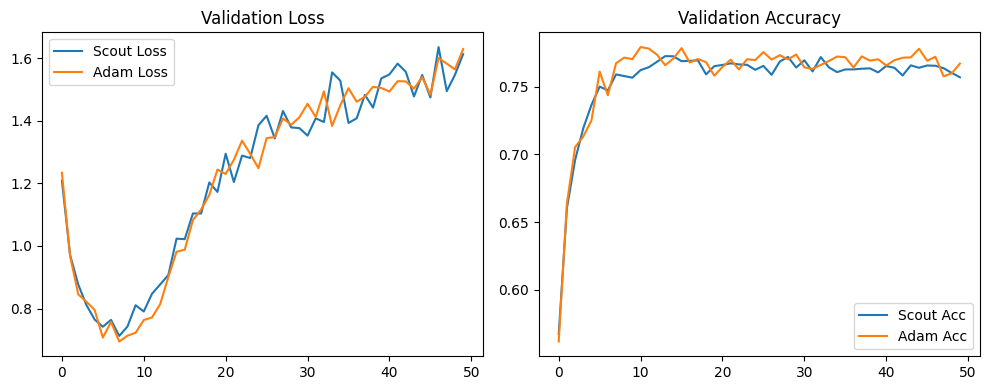

In [14]:
"""scout_opt_cifar10.py

Quick‑and‑dirty *large(-ish)* demo of the scout–guided optimizer on CIFAR‑10.

• Dataset  : CIFAR‑10 (50 k train / 10 k test, 32×32 colour)
• Model    : lightweight CNN (~0.6 M params)
• Baseline : Adam
• ScoutOpt : wraps Adam, periodically probes 2 directions
             (current grad + one random orthogonal) with
             a 1‑step look‑ahead on the same mini‑batch.

Run from a Jupyter cell (accepts the stray -f arg) or from CLI:
    python scout_opt_cifar10.py --gpu  
-------------------------------------------------------"""

import argparse, time, pathlib, random, sys
from typing import List

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# ------------------------------------------------------------------ #
#  1. A small-ish CNN                                                #
# ------------------------------------------------------------------ #
class SmallCNN(nn.Module):
    def __init__(self, n_classes: int = 10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.fc1   = nn.Linear(256 * 4 * 4, 256)
        self.fc2   = nn.Linear(256, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32→16
        x = self.pool(F.relu(self.conv2(x)))  # 16→8
        x = self.pool(F.relu(self.conv3(x)))  # 8 →4
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# ------------------------------------------------------------------ #
#  2. Scout‑guided Optimizer                                         #
# ------------------------------------------------------------------ #
class ScoutOptimizer(optim.Optimizer):
    """Light wrapper that adds a cheap 1‑step look‑ahead probe."""

    def __init__(self, params, base_opt_cls, *, lr=3e-4, scout_every=100, scout_radius=5e-4, **base_kwargs):
        param_list = list(params)
        self.base = base_opt_cls(param_list, lr=lr, **base_kwargs)
        super().__init__(param_list, defaults=dict(lr=lr))
        self.s_every  = scout_every
        self.radius   = scout_radius
        self._step_id = 0
        self._params  = param_list

    @staticmethod
    @torch.no_grad()
    def _flatten(tensors: List[torch.Tensor]):
        return torch.cat([t.reshape(-1) for t in tensors])

    @torch.no_grad()
    def _apply_delta(self, vec_flat: torch.Tensor, coef: float):
        offset = 0
        for p in self._params:
            n = p.numel()
            p.add_(vec_flat[offset:offset+n].view_as(p), alpha=coef)
            offset += n

    @staticmethod
    @torch.no_grad()
    def _rand_orthogonal(base: torch.Tensor):
        r = torch.randn_like(base)
        proj = (r @ base) / (base @ base + 1e-12)
        ortho = r - proj * base
        return ortho / (ortho.norm() + 1e-12)

    def step(self, closure=None):
        if closure is None:
            raise RuntimeError("ScoutOptimizer needs a closure that returns loss and does backward()")

        loss = closure()
        self._step_id += 1

        if self._step_id % self.s_every == 0:
            grad_flat = self._flatten([p.grad for p in self._params])
            grad_norm = grad_flat.norm() + 1e-12
            grad_dir  = grad_flat / grad_norm
            dirs = [grad_dir, self._rand_orthogonal(grad_dir)]

            best_dir, best_loss = None, loss.item()
            for d in dirs:
                self._apply_delta(d, +self.radius)
                probe_loss = closure()
                self._apply_delta(d, -self.radius)
                if probe_loss < best_loss:
                    best_loss = probe_loss
                    best_dir  = d
            if best_dir is not None:
                new_grad = best_dir * grad_norm
                offset = 0
                for p in self._params:
                    n = p.numel()
                    p.grad.copy_(new_grad[offset:offset+n].view_as(p))
                    offset += n

        self.base.step()
        return loss

# ------------------------------------------------------------------ #
#  3. Training / evaluation loops                                    #
# ------------------------------------------------------------------ #
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    tot_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        tot_loss += criterion(out, y).item() * x.size(0)
        pred = out.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return tot_loss / total, correct / total


def train_one_epoch(model, loader, criterion, opt, device, log_every=100):
    model.train()
    running = 0.0
    for i, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        def closure():
            opt.base.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            return loss
        loss = opt.step(closure)
        running += loss.item()
        if (i + 1) % log_every == 0:
            print(f"  batch {i+1}/{len(loader)}  loss {running/log_every:.3f}")
            running = 0.0


# ------------------------------------------------------------------ #
#  4. Baseline Adam Check                                                     #
# ------------------------------------------------------------------ #


def run_baseline_adam(epochs=6, batch=128, lr=3e-4, results=None):
    print("\nBaseline: Adam")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))
    ])
    root = str(pathlib.Path.home() / ".torchdata")
    train_set = datasets.CIFAR10(root=root, train=True,  download=True, transform=transform)
    test_set  = datasets.CIFAR10(root=root, train=False, download=True, transform=transform)
    train_loader = DataLoader(train_set, batch_size=batch, shuffle=True,  num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_set,  batch_size=256,   shuffle=False, num_workers=2, pin_memory=True)

    model = SmallCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=1e-4)

    for ep in range(1, epochs+1):
        print(f"\nEpoch {ep}/{epochs}")
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

        val_loss, val_acc = evaluate(model, test_loader, criterion, device)
        print(f"  val_loss={val_loss:.3f}  val_acc={val_acc:.3f}")
        if results is not None:
            results['adam_loss'].append(val_loss)
            results['adam_acc'].append(val_acc)

# ------------------------------------------------------------------ #
#  5. Main                                                           #
# ------------------------------------------------------------------ #

def main():
    # ✅ Fix: Inject --gpu before parsing arguments if running inside Jupyter

    if '--gpu' not in sys.argv and '--cpu' not in sys.argv:
        sys.argv += ['--gpu']

    parser = argparse.ArgumentParser()
    parser.add_argument('--epochs', type=int, default=50)
    parser.add_argument('--batch',  type=int, default=128)
    parser.add_argument('--lr',     type=float, default=3e-4)
    parser.add_argument('--scout_every',  type=int, default=100)
    parser.add_argument('--scout_radius', type=float, default=5e-4)
    parser.add_argument('--gpu', action='store_true')
    args, _ = parser.parse_known_args()

    device = torch.device('cuda' if args.gpu and torch.cuda.is_available() else 'cpu')
    print("sys.argv:", sys.argv)
    print("args.gpu:", args.gpu)
    print("Device:", device)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))
    ])

    root = str(pathlib.Path.home() / ".torchdata")
    train_set = datasets.CIFAR10(root=root, train=True,  download=True, transform=transform)
    test_set  = datasets.CIFAR10(root=root, train=False, download=True, transform=transform)

    train_loader = DataLoader(train_set, batch_size=args.batch, shuffle=True,  num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_set,  batch_size=256,       shuffle=False, num_workers=2, pin_memory=True)

    model = SmallCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    opt = ScoutOptimizer(model.parameters(), optim.Adam,
                         lr=args.lr,
                         scout_every=args.scout_every,
                         scout_radius=args.scout_radius,
                         betas=(0.9, 0.999), weight_decay=1e-4)

    results = {'scout_loss': [], 'scout_acc': [], 'adam_loss': [], 'adam_acc': []}

    for ep in range(1, args.epochs+1):
        print(f"\nEpoch {ep}/{args.epochs}")
        start = time.time()
        train_one_epoch(model, train_loader, criterion, opt, device)
        val_loss, val_acc = evaluate(model, test_loader, criterion, device)
        print(f"  val_loss={val_loss:.3f}  val_acc={val_acc:.3f}  ({time.time() - start:.1f}s)")
        results['scout_loss'].append(val_loss)
        results['scout_acc'].append(val_acc)

    torch.save(model.state_dict(), "scout_cnn.pth")
    print("Model saved to scout_cnn.pth")

    run_baseline_adam(epochs=args.epochs, batch=args.batch, lr=args.lr, results=results)

    print("\nFinal comparison table:")
    for i in range(args.epochs):
        print(f"Epoch {i+1:>2}:  Scout acc = {results['scout_acc'][i]*100:.2f}%  |  Adam acc = {results['adam_acc'][i]*100:.2f}%")

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(results['scout_loss'], label='Scout Loss')
    plt.plot(results['adam_loss'],  label='Adam Loss')
    plt.legend()
    plt.title("Validation Loss")

    plt.subplot(1, 2, 2)
    plt.plot(results['scout_acc'], label='Scout Acc')
    plt.plot(results['adam_acc'],  label='Adam Acc')
    plt.legend()
    plt.title("Validation Accuracy")
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()



# 100 steps down scouts path test 

In [6]:
"""scout_opt_cifar10.py

Quick‑and‑dirty *large(-ish)* demo of the scout–guided optimizer on CIFAR‑10.

• Dataset  : CIFAR‑10 (50 k train / 10 k test, 32×32 colour)
• Model    : lightweight CNN (~0.6 M params)
• Baseline : Adam
• ScoutOpt : wraps Adam, periodically probes 2 directions
             (current grad + one random orthogonal) with
             a 1‑step look‑ahead on the same mini‑batch.

Run from a Jupyter cell (accepts the stray -f arg) or from CLI:
    python scout_opt_cifar10.py --gpu  

-------------------------------------------------------"""

import argparse, time, pathlib, random
from typing import List

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# ------------------------------------------------------------------ #
#  1. A small-ish CNN                                                #
# ------------------------------------------------------------------ #
class SmallCNN(nn.Module):
    def __init__(self, n_classes: int = 10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.fc1   = nn.Linear(256 * 4 * 4, 256)
        self.fc2   = nn.Linear(256, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32→16
        x = self.pool(F.relu(self.conv2(x)))  # 16→8
        x = self.pool(F.relu(self.conv3(x)))  # 8 →4
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# ------------------------------------------------------------------ #
#  2. Scout‑guided Optimizer                                         #
# ------------------------------------------------------------------ #
class ScoutOptimizer(optim.Optimizer):
    """Light wrapper that adds a cheap 1‑step look‑ahead probe."""

    def __init__(self, params, base_opt_cls, *, lr=3e-4, scout_every=100, scout_radius=5e-4, **base_kwargs):
        params = list(params)  # <– FIXED: convert generator to reusable list
        self.base = base_opt_cls(params, lr=lr, **base_kwargs)
        super().__init__(params, defaults=dict(lr=lr))
        self.s_every  = scout_every
        self.radius   = scout_radius
        self._step_id = 0
        self._params  = list(params)

    @staticmethod
    @torch.no_grad()
    def _flatten(tensors: List[torch.Tensor]):
        return torch.cat([t.reshape(-1) for t in tensors])

    @torch.no_grad()
    def _apply_delta(self, vec_flat: torch.Tensor, coef: float):
        offset = 0
        for p in self._params:
            n = p.numel()
            p.add_(vec_flat[offset:offset+n].view_as(p), alpha=coef)
            offset += n

    @staticmethod
    @torch.no_grad()
    def _rand_orthogonal(base: torch.Tensor):
        r = torch.randn_like(base)
        proj = (r @ base) / (base @ base + 1e-12)
        ortho = r - proj * base
        return ortho / (ortho.norm() + 1e-12)

    def step(self, closure=None):
        if closure is None:
            raise RuntimeError("ScoutOptimizer needs a closure that returns loss and does backward()")

        loss = closure()
        self._step_id += 1

        if self._step_id % self.s_every == 0:
            grad_flat = self._flatten([p.grad for p in self._params])
            grad_norm = grad_flat.norm() + 1e-12
            grad_dir  = grad_flat / grad_norm
            dirs = [grad_dir, self._rand_orthogonal(grad_dir)]

            best_dir, best_loss = None, loss.item()
            best_step = 0.0
            for d in dirs:
                for step in range(1, 101):  # probe up to 100 steps
                    step_size = self.radius * step
                    self._apply_delta(d, +step_size)
                    probe_loss = closure()
                    self._apply_delta(d, -step_size)
                    if probe_loss < best_loss:
                        best_loss = probe_loss
                        best_dir  = d.clone()
                        best_step = step_size

            if best_dir is not None:
                new_grad = best_dir * grad_norm
                offset = 0
                for p in self._params:
                    n = p.numel()
                    p.grad.copy_(new_grad[offset:offset+n].view_as(p))
                    offset += n

        self.base.step()
        return loss

# ------------------------------------------------------------------ #
#  3. Training / evaluation loops                                    #
# ------------------------------------------------------------------ #
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    tot_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        tot_loss += criterion(out, y).item() * x.size(0)
        pred = out.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return tot_loss / total, correct / total


def train_one_epoch(model, loader, criterion, opt, device, log_every=100):
    model.train()
    running = 0.0
    for i, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        def closure():
            opt.base.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            return loss
        loss = opt.step(closure)
        running += loss.item()
        if (i + 1) % log_every == 0:
            print(f"  batch {i+1}/{len(loader)}  loss {running/log_every:.3f}")
            running = 0.0

# ------------------------------------------------------------------ #
#  4. Main                                                           #
# ------------------------------------------------------------------ #

def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('--epochs', type=int, default=50)
    parser.add_argument('--batch',  type=int, default=128)
    parser.add_argument('--lr',     type=float, default=3e-4)
    parser.add_argument('--scout_every',  type=int, default=100)
    parser.add_argument('--scout_radius', type=float, default=5e-4)
    parser.add_argument('--gpu', action='store_true')
    args, _ = parser.parse_known_args()

    device = torch.device('cuda' if args.gpu and torch.cuda.is_available() else 'cpu')
    print('Device:', device)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))
    ])

    train_set = datasets.CIFAR10(root='~/.torchdata', train=True,  download=True, transform=transform)
    test_set  = datasets.CIFAR10(root='~/.torchdata', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_set, batch_size=args.batch, shuffle=True,  num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_set,  batch_size=256,       shuffle=False, num_workers=2, pin_memory=True)

    model = SmallCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    opt = ScoutOptimizer(model.parameters(), optim.Adam,
                         lr=args.lr,
                         scout_every=args.scout_every,
                         scout_radius=args.scout_radius,
                         betas=(0.9, 0.999), weight_decay=1e-4)

    for ep in range(1, args.epochs+1):
        print(f"\nEpoch {ep}/{args.epochs}")
        start = time.time()
        train_one_epoch(model, train_loader, criterion, opt, device)
        val_loss, val_acc = evaluate(model, test_loader, criterion, device)
        print(f"  val_loss={val_loss:.3f}  val_acc={val_acc:.3f}  ({time.time() - start:.1f}s)")

    torch.save(model.state_dict(), "scout_cnn.pth")
    print("Model saved to scout_cnn.pth")


if __name__ == '__main__':
    main()


Device: cuda
Files already downloaded and verified
Files already downloaded and verified

Epoch 1/50
  batch 100/391  loss 1.827
  batch 200/391  loss 1.483
  batch 300/391  loss 1.346
  val_loss=1.192  val_acc=0.570  (24.0s)

Epoch 2/50
  batch 100/391  loss 1.155
  batch 200/391  loss 1.097
  batch 300/391  loss 1.055
  val_loss=0.981  val_acc=0.656  (25.4s)

Epoch 3/50
  batch 100/391  loss 0.938
  batch 200/391  loss 0.909
  batch 300/391  loss 0.885
  val_loss=0.901  val_acc=0.692  (25.0s)

Epoch 4/50
  batch 100/391  loss 0.796
  batch 200/391  loss 0.767
  batch 300/391  loss 0.784
  val_loss=0.840  val_acc=0.712  (22.9s)

Epoch 5/50
  batch 100/391  loss 0.687
  batch 200/391  loss 0.683
  batch 300/391  loss 0.684
  val_loss=0.802  val_acc=0.726  (23.1s)

Epoch 6/50
  batch 100/391  loss 0.597
  batch 200/391  loss 0.602
  batch 300/391  loss 0.586
  val_loss=0.759  val_acc=0.742  (23.2s)

Epoch 7/50
  batch 100/391  loss 0.544
  batch 200/391  loss 0.506
  batch 300/391  loss

Device: cuda
Files already downloaded and verified
Files already downloaded and verified

===== Training with ADAM =====
Epoch 1/30
  batch 100/391  loss 1.830
  batch 200/391  loss 1.451
  batch 300/391  loss 1.333
  val_loss=1.173  val_acc=0.580  (15.7s)
Epoch 2/30
  batch 100/391  loss 1.164
  batch 200/391  loss 1.075
  batch 300/391  loss 1.040
  val_loss=0.973  val_acc=0.665  (15.6s)
Epoch 3/30
  batch 100/391  loss 0.911
  batch 200/391  loss 0.890
  batch 300/391  loss 0.881
  val_loss=0.887  val_acc=0.692  (16.3s)
Epoch 4/30
  batch 100/391  loss 0.791
  batch 200/391  loss 0.761
  batch 300/391  loss 0.743
  val_loss=0.781  val_acc=0.733  (17.4s)
Epoch 5/30
  batch 100/391  loss 0.670
  batch 200/391  loss 0.679
  batch 300/391  loss 0.649
  val_loss=0.746  val_acc=0.744  (18.1s)
Epoch 6/30
  batch 100/391  loss 0.585
  batch 200/391  loss 0.558
  batch 300/391  loss 0.587
  val_loss=0.732  val_acc=0.750  (17.8s)
Epoch 7/30
  batch 100/391  loss 0.502
  batch 200/391  loss 0.

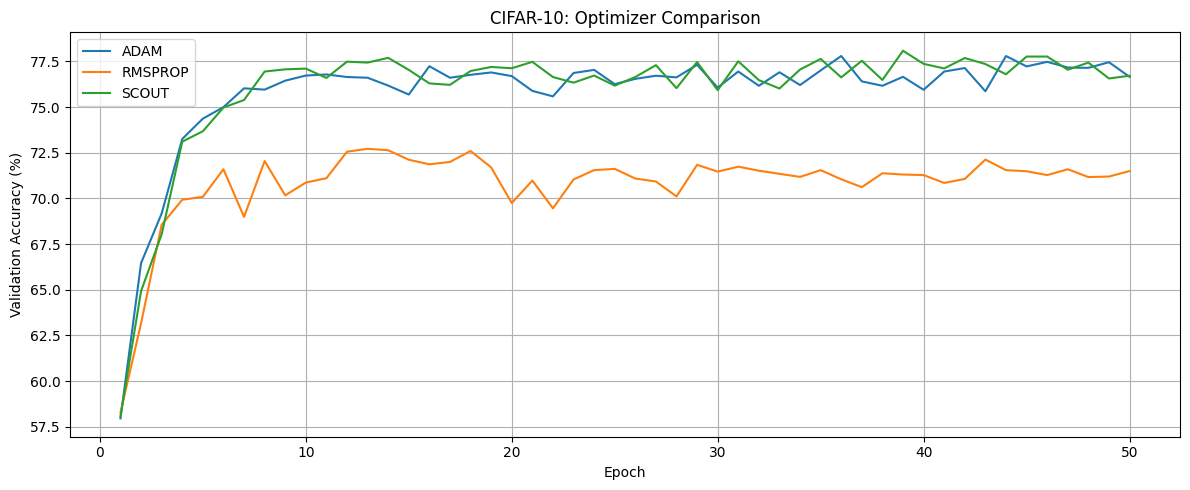

In [7]:
import argparse, time, pathlib, random
from typing import List

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# ------------------------------------------------------------------ #
#  1. A small-ish CNN                                                #
# ------------------------------------------------------------------ #
class SmallCNN(nn.Module):
    def __init__(self, n_classes: int = 10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.fc1   = nn.Linear(256 * 4 * 4, 256)
        self.fc2   = nn.Linear(256, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# ------------------------------------------------------------------ #
#  2. Scout‑guided Optimizer                                         #
# ------------------------------------------------------------------ #
class ScoutOptimizer(optim.Optimizer):
    def __init__(self, params, base_opt_cls, *, lr=3e-4, scout_every=100, scout_radius=5e-4, **base_kwargs):
        params = list(params)
        self.base = base_opt_cls(params, lr=lr, **base_kwargs)
        super().__init__(params, defaults=dict(lr=lr))
        self.s_every  = scout_every
        self.radius   = scout_radius
        self._step_id = 0
        self._params  = list(params)

    @staticmethod
    @torch.no_grad()
    def _flatten(tensors: List[torch.Tensor]):
        return torch.cat([t.reshape(-1) for t in tensors])

    @torch.no_grad()
    def _apply_delta(self, vec_flat: torch.Tensor, coef: float):
        offset = 0
        for p in self._params:
            n = p.numel()
            p.add_(vec_flat[offset:offset+n].view_as(p), alpha=coef)
            offset += n

    @staticmethod
    @torch.no_grad()
    def _rand_orthogonal(base: torch.Tensor):
        r = torch.randn_like(base)
        proj = (r @ base) / (base @ base + 1e-12)
        ortho = r - proj * base
        return ortho / (ortho.norm() + 1e-12)

    def step(self, closure=None):
        if closure is None:
            raise RuntimeError("ScoutOptimizer needs a closure that returns loss and does backward()")
        loss = closure()
        self._step_id += 1
        if self._step_id % self.s_every == 0:
            grad_flat = self._flatten([p.grad for p in self._params])
            grad_norm = grad_flat.norm() + 1e-12
            grad_dir  = grad_flat / grad_norm
            dirs = [grad_dir, self._rand_orthogonal(grad_dir)]
            best_dir, best_loss = None, loss.item()
            for d in dirs:
                for step in range(1, 101):
                    step_size = self.radius * step
                    self._apply_delta(d, +step_size)
                    probe_loss = closure()
                    self._apply_delta(d, -step_size)
                    if probe_loss < best_loss:
                        best_loss = probe_loss
                        best_dir  = d.clone()
            if best_dir is not None:
                new_grad = best_dir * grad_norm
                offset = 0
                for p in self._params:
                    n = p.numel()
                    p.grad.copy_(new_grad[offset:offset+n].view_as(p))
                    offset += n
        self.base.step()
        return loss

# ------------------------------------------------------------------ #
#  3. Training / evaluation loops                                    #
# ------------------------------------------------------------------ #
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    tot_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        tot_loss += criterion(out, y).item() * x.size(0)
        pred = out.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return tot_loss / total, correct / total

def train_one_epoch(model, loader, criterion, opt, device, log_every=100):
    model.train()
    running = 0.0
    for i, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        def closure():
            opt.base.zero_grad() if hasattr(opt, 'base') else opt.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            return loss
        loss = opt.step(closure)
        running += loss.item()
        if (i + 1) % log_every == 0:
            print(f"  batch {i+1}/{len(loader)}  loss {running/log_every:.3f}")
            running = 0.0

# ------------------------------------------------------------------ #
#  4. Unified Run: Compare Adam, RMSprop, Scout                      #
# ------------------------------------------------------------------ #
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Device:', device)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    train_set = datasets.CIFAR10(root='~/.torchdata', train=True, download=True, transform=transform)
    test_set  = datasets.CIFAR10(root='~/.torchdata', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_set, batch_size=128, shuffle=True,  num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_set,  batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

    results = {}
    for opt_name in ['adam', 'rmsprop', 'scout']:
        print(f"\n===== Training with {opt_name.upper()} =====")
        model = SmallCNN().to(device)
        criterion = nn.CrossEntropyLoss()
        if opt_name == 'scout':
            opt = ScoutOptimizer(model.parameters(), optim.Adam, lr=3e-4, scout_every=100, scout_radius=5e-4,
                                 betas=(0.9, 0.999), weight_decay=1e-4)
        elif opt_name == 'adam':
            opt = optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999), weight_decay=1e-4)
        else:
            opt = optim.RMSprop(model.parameters(), lr=3e-4, momentum=0.9, weight_decay=1e-4)

        val_losses, val_accs = [], []
        for ep in range(1, 51):  # 50 epochs
            print(f"Epoch {ep}/30")
            start = time.time()
            train_one_epoch(model, train_loader, criterion, opt, device)
            val_loss, val_acc = evaluate(model, test_loader, criterion, device)
            print(f"  val_loss={val_loss:.3f}  val_acc={val_acc:.3f}  ({time.time() - start:.1f}s)")
            val_losses.append(val_loss)
            val_accs.append(val_acc)

        results[opt_name] = (val_losses, val_accs)

    plt.figure(figsize=(12, 5))
    for name, (losses, accs) in results.items():
        plt.plot(range(1, len(accs)+1), [a*100 for a in accs], label=f'{name.upper()}')

    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy (%)")
    plt.title("CIFAR-10: Optimizer Comparison")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()


# Tiny-Imagenet-200 Test
Scout vs RMSProp and Adam on 50 epochs training Resnet18. 

Epoch  1:  Scout acc = 13.46%  |  Adam acc = 15.03%  |  RMSprop acc = 11.01%
Epoch  2:  Scout acc = 19.08%  |  Adam acc = 20.65%  |  RMSprop acc = 4.61%
Epoch  3:  Scout acc = 24.21%  |  Adam acc = 27.46%  |  RMSprop acc = 6.52%
Epoch  4:  Scout acc = 31.05%  |  Adam acc = 30.16%  |  RMSprop acc = 26.14%
Epoch  5:  Scout acc = 33.84%  |  Adam acc = 29.13%  |  RMSprop acc = 26.89%
Epoch  6:  Scout acc = 31.18%  |  Adam acc = 34.70%  |  RMSprop acc = 18.86%
Epoch  7:  Scout acc = 31.92%  |  Adam acc = 34.32%  |  RMSprop acc = 32.87%
Epoch  8:  Scout acc = 31.19%  |  Adam acc = 31.81%  |  RMSprop acc = 30.26%
Epoch  9:  Scout acc = 31.47%  |  Adam acc = 32.27%  |  RMSprop acc = 30.78%
Epoch 10:  Scout acc = 31.45%  |  Adam acc = 27.82%  |  RMSprop acc = 29.25%
Epoch 11:  Scout acc = 31.61%  |  Adam acc = 30.51%  |  RMSprop acc = 29.99%
Epoch 12:  Scout acc = 31.50%  |  Adam acc = 32.33%  |  RMSprop acc = 26.88%
Epoch 13:  Scout acc = 29.74%  |  Adam acc = 30.20%  |  RMSprop acc = 29.32%
E

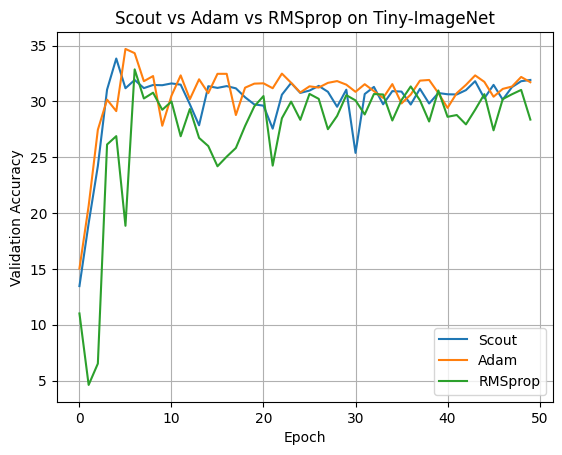

In [20]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet18
import matplotlib.pyplot as plt

# 🔒 Reproducibility: Set seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(105)  # Change this to try different random initializations

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ScoutOptimizer(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer_cls, scout_step_interval=5, **kwargs):
        self.base_optimizer = base_optimizer_cls(params, **kwargs)
        self.step_count = 0
        self.scout_step_interval = scout_step_interval
        self.eps = 1e-8
        self.param_groups = self.base_optimizer.param_groups

    def step(self, closure=None):
        loss = closure() if closure is not None else None
        self.step_count += 1

        grads = [p.grad.view(-1) for group in self.param_groups for p in group['params'] if p.grad is not None]
        flat_grad = torch.cat(grads)
        norm_g = flat_grad / (flat_grad.norm() + self.eps)

        rand_dir = torch.randn_like(norm_g)
        proj = torch.dot(norm_g, rand_dir) * norm_g
        ortho = rand_dir - proj
        ortho /= ortho.norm() + self.eps

        if self.step_count % self.scout_step_interval == 0:
            idx = 0
            with torch.no_grad():
                for group in self.param_groups:
                    for p in group['params']:
                        if p.grad is None:
                            continue
                        numel = p.numel()
                        noise = 0.01 * ortho[idx:idx+numel].view_as(p)
                        p.add_(noise)
                        idx += numel

        self.base_optimizer.step()
        return loss

# Define transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Adjust path to your local unzipped dataset
data_dir = r"C:\Users\Machine-Learning\Downloads\tiny-imagenet-200"
train_data = torchvision.datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform)
val_data = torchvision.datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform)


train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)

        def closure():
            if isinstance(optimizer, ScoutOptimizer):
                optimizer.base_optimizer.zero_grad()
            else:
                optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            return loss

        loss = optimizer.step(closure)
        total_loss += loss.item()
    return total_loss / len(loader)

def validate(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            _, predicted = outputs.max(1)
            total += y.size(0)
            correct += predicted.eq(y).sum().item()
    return 100. * correct / total

def get_model():
    model = resnet18(num_classes=200)
    return model.to(device)

# Initialize
scout_model = get_model()
adam_model = get_model()
rms_model = get_model()

criterion = nn.CrossEntropyLoss()
scout_optim = ScoutOptimizer(scout_model.parameters(), torch.optim.Adam, lr=1e-3, scout_step_interval=5)
adam_optim = torch.optim.Adam(adam_model.parameters(), lr=1e-3)
rms_optim = torch.optim.RMSprop(rms_model.parameters(), lr=1e-3)

scout_accs, adam_accs, rms_accs = [], [], []

# Training loop
for epoch in range(1, 51):
    train_one_epoch(scout_model, train_loader, criterion, scout_optim, device)
    train_one_epoch(adam_model, train_loader, criterion, adam_optim, device)
    train_one_epoch(rms_model, train_loader, criterion, rms_optim, device)

    scout_acc = validate(scout_model, val_loader, device)
    adam_acc = validate(adam_model, val_loader, device)
    rms_acc = validate(rms_model, val_loader, device)

    scout_accs.append(scout_acc)
    adam_accs.append(adam_acc)
    rms_accs.append(rms_acc)

    print(f"Epoch {epoch:2}:  Scout acc = {scout_acc:.2f}%  |  Adam acc = {adam_acc:.2f}%  |  RMSprop acc = {rms_acc:.2f}%")

# Plot
plt.plot(scout_accs, label='Scout')
plt.plot(adam_accs, label='Adam')
plt.plot(rms_accs, label='RMSprop')
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Scout vs Adam vs RMSprop on Tiny-ImageNet")
plt.legend()
plt.grid(True)
plt.show()


Epoch  1:  Scout acc = 11.78%  |  Adam acc = 13.06%  |  RMSprop acc = 5.84%
Epoch  2:  Scout acc = 13.45%  |  Adam acc = 22.63%  |  RMSprop acc = 13.25%
Epoch  3:  Scout acc = 20.69%  |  Adam acc = 27.01%  |  RMSprop acc = 18.57%
Epoch  4:  Scout acc = 31.91%  |  Adam acc = 25.96%  |  RMSprop acc = 27.36%
Epoch  5:  Scout acc = 32.93%  |  Adam acc = 32.50%  |  RMSprop acc = 23.60%
Epoch  6:  Scout acc = 34.73%  |  Adam acc = 31.75%  |  RMSprop acc = 31.26%
Epoch  7:  Scout acc = 31.52%  |  Adam acc = 34.11%  |  RMSprop acc = 29.76%
Epoch  8:  Scout acc = 30.84%  |  Adam acc = 30.06%  |  RMSprop acc = 23.87%
Epoch  9:  Scout acc = 29.62%  |  Adam acc = 28.77%  |  RMSprop acc = 23.61%
Epoch 10:  Scout acc = 32.58%  |  Adam acc = 31.93%  |  RMSprop acc = 27.67%
Epoch 11:  Scout acc = 31.64%  |  Adam acc = 30.21%  |  RMSprop acc = 29.99%
Epoch 12:  Scout acc = 30.93%  |  Adam acc = 31.44%  |  RMSprop acc = 30.43%
Epoch 13:  Scout acc = 32.01%  |  Adam acc = 30.29%  |  RMSprop acc = 29.88%


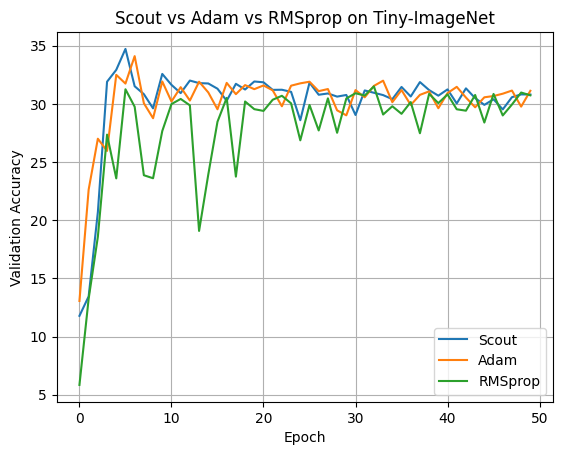

In [21]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet18
import matplotlib.pyplot as plt

# 🔒 Reproducibility: Set seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)  # Change this to try different random initializations

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



class ScoutOptimizer(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer_cls, scout_step_interval=5, **kwargs):
        self.base_optimizer = base_optimizer_cls(params, **kwargs)
        self.step_count = 0
        self.scout_step_interval = scout_step_interval
        self.eps = 1e-8
        self.param_groups = self.base_optimizer.param_groups

    def step(self, closure=None):
        loss = closure() if closure is not None else None
        self.step_count += 1

        grads = [p.grad.view(-1) for group in self.param_groups for p in group['params'] if p.grad is not None]
        flat_grad = torch.cat(grads)
        norm_g = flat_grad / (flat_grad.norm() + self.eps)

        rand_dir = torch.randn_like(norm_g)
        proj = torch.dot(norm_g, rand_dir) * norm_g
        ortho = rand_dir - proj
        ortho /= ortho.norm() + self.eps

        if self.step_count % self.scout_step_interval == 0:
            idx = 0
            with torch.no_grad():
                for group in self.param_groups:
                    for p in group['params']:
                        if p.grad is None:
                            continue
                        numel = p.numel()
                        noise = 0.01 * ortho[idx:idx+numel].view_as(p)
                        p.add_(noise)
                        idx += numel

        self.base_optimizer.step()
        return loss

# Define transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Adjust path to your local unzipped dataset
data_dir = r"C:\Users\Machine-Learning\Downloads\tiny-imagenet-200"
train_data = torchvision.datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform)
val_data = torchvision.datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform)


train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)

        def closure():
            if isinstance(optimizer, ScoutOptimizer):
                optimizer.base_optimizer.zero_grad()
            else:
                optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            return loss

        loss = optimizer.step(closure)
        total_loss += loss.item()
    return total_loss / len(loader)

def validate(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            _, predicted = outputs.max(1)
            total += y.size(0)
            correct += predicted.eq(y).sum().item()
    return 100. * correct / total

def get_model():
    model = resnet18(num_classes=200)
    return model.to(device)

# Initialize
scout_model = get_model()
adam_model = get_model()
rms_model = get_model()

criterion = nn.CrossEntropyLoss()
scout_optim = ScoutOptimizer(scout_model.parameters(), torch.optim.Adam, lr=1e-3, scout_step_interval=5)
adam_optim = torch.optim.Adam(adam_model.parameters(), lr=1e-3)
rms_optim = torch.optim.RMSprop(rms_model.parameters(), lr=1e-3)

scout_accs, adam_accs, rms_accs = [], [], []

# Training loop
for epoch in range(1, 51):
    train_one_epoch(scout_model, train_loader, criterion, scout_optim, device)
    train_one_epoch(adam_model, train_loader, criterion, adam_optim, device)
    train_one_epoch(rms_model, train_loader, criterion, rms_optim, device)

    scout_acc = validate(scout_model, val_loader, device)
    adam_acc = validate(adam_model, val_loader, device)
    rms_acc = validate(rms_model, val_loader, device)

    scout_accs.append(scout_acc)
    adam_accs.append(adam_acc)
    rms_accs.append(rms_acc)

    print(f"Epoch {epoch:2}:  Scout acc = {scout_acc:.2f}%  |  Adam acc = {adam_acc:.2f}%  |  RMSprop acc = {rms_acc:.2f}%")

# Plot
plt.plot(scout_accs, label='Scout')
plt.plot(adam_accs, label='Adam')
plt.plot(rms_accs, label='RMSprop')
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Scout vs Adam vs RMSprop on Tiny-ImageNet")
plt.legend()
plt.grid(True)
plt.show()


Epoch  1:  Scout acc = 12.20%  |  Adam acc = 16.47%  |  RMSprop acc = 11.74%
Epoch  2:  Scout acc = 18.04%  |  Adam acc = 21.27%  |  RMSprop acc = 18.52%
Epoch  3:  Scout acc = 27.25%  |  Adam acc = 22.84%  |  RMSprop acc = 16.02%
Epoch  4:  Scout acc = 26.20%  |  Adam acc = 31.43%  |  RMSprop acc = 24.42%
Epoch  5:  Scout acc = 33.47%  |  Adam acc = 31.74%  |  RMSprop acc = 26.37%
Epoch  6:  Scout acc = 35.10%  |  Adam acc = 31.71%  |  RMSprop acc = 30.03%
Epoch  7:  Scout acc = 34.89%  |  Adam acc = 32.79%  |  RMSprop acc = 29.24%
Epoch  8:  Scout acc = 32.98%  |  Adam acc = 31.20%  |  RMSprop acc = 29.13%
Epoch  9:  Scout acc = 31.32%  |  Adam acc = 32.47%  |  RMSprop acc = 17.29%
Epoch 10:  Scout acc = 30.05%  |  Adam acc = 31.41%  |  RMSprop acc = 30.09%
Epoch 11:  Scout acc = 27.42%  |  Adam acc = 31.27%  |  RMSprop acc = 29.38%
Epoch 12:  Scout acc = 31.24%  |  Adam acc = 31.58%  |  RMSprop acc = 28.04%
Epoch 13:  Scout acc = 28.24%  |  Adam acc = 30.91%  |  RMSprop acc = 26.35%

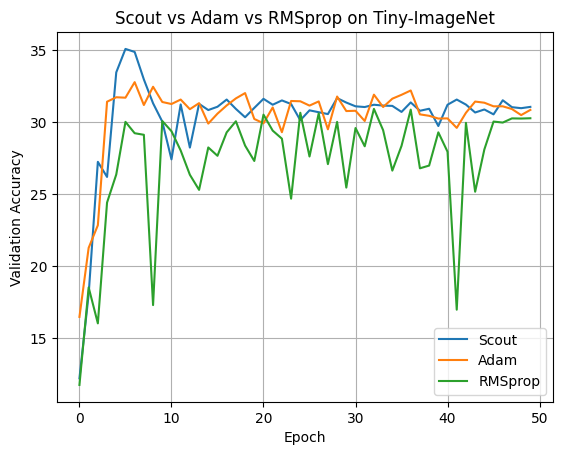

In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet18
import matplotlib.pyplot as plt

# 🔒 Reproducibility: Set seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(28)  # Change this to try different random initializations

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



class ScoutOptimizer(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer_cls, scout_step_interval=5, **kwargs):
        self.base_optimizer = base_optimizer_cls(params, **kwargs)
        self.step_count = 0
        self.scout_step_interval = scout_step_interval
        self.eps = 1e-8
        self.param_groups = self.base_optimizer.param_groups

    def step(self, closure=None):
        loss = closure() if closure is not None else None
        self.step_count += 1

        grads = [p.grad.view(-1) for group in self.param_groups for p in group['params'] if p.grad is not None]
        flat_grad = torch.cat(grads)
        norm_g = flat_grad / (flat_grad.norm() + self.eps)

        rand_dir = torch.randn_like(norm_g)
        proj = torch.dot(norm_g, rand_dir) * norm_g
        ortho = rand_dir - proj
        ortho /= ortho.norm() + self.eps

        if self.step_count % self.scout_step_interval == 0:
            idx = 0
            with torch.no_grad():
                for group in self.param_groups:
                    for p in group['params']:
                        if p.grad is None:
                            continue
                        numel = p.numel()
                        noise = 0.01 * ortho[idx:idx+numel].view_as(p)
                        p.add_(noise)
                        idx += numel

        self.base_optimizer.step()
        return loss

# Define transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Adjust path to your local unzipped dataset
data_dir = r"C:\Users\Machine-Learning\Downloads\tiny-imagenet-200"
train_data = torchvision.datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform)
val_data = torchvision.datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform)


train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)

        def closure():
            if isinstance(optimizer, ScoutOptimizer):
                optimizer.base_optimizer.zero_grad()
            else:
                optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            return loss

        loss = optimizer.step(closure)
        total_loss += loss.item()
    return total_loss / len(loader)

def validate(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            _, predicted = outputs.max(1)
            total += y.size(0)
            correct += predicted.eq(y).sum().item()
    return 100. * correct / total

def get_model():
    model = resnet18(num_classes=200)
    return model.to(device)

# Initialize
scout_model = get_model()
adam_model = get_model()
rms_model = get_model()

criterion = nn.CrossEntropyLoss()
scout_optim = ScoutOptimizer(scout_model.parameters(), torch.optim.Adam, lr=1e-3, scout_step_interval=5)
adam_optim = torch.optim.Adam(adam_model.parameters(), lr=1e-3)
rms_optim = torch.optim.RMSprop(rms_model.parameters(), lr=1e-3)

scout_accs, adam_accs, rms_accs = [], [], []

# Training loop
for epoch in range(1, 51):
    train_one_epoch(scout_model, train_loader, criterion, scout_optim, device)
    train_one_epoch(adam_model, train_loader, criterion, adam_optim, device)
    train_one_epoch(rms_model, train_loader, criterion, rms_optim, device)

    scout_acc = validate(scout_model, val_loader, device)
    adam_acc = validate(adam_model, val_loader, device)
    rms_acc = validate(rms_model, val_loader, device)

    scout_accs.append(scout_acc)
    adam_accs.append(adam_acc)
    rms_accs.append(rms_acc)

    print(f"Epoch {epoch:2}:  Scout acc = {scout_acc:.2f}%  |  Adam acc = {adam_acc:.2f}%  |  RMSprop acc = {rms_acc:.2f}%")

# Plot
plt.plot(scout_accs, label='Scout')
plt.plot(adam_accs, label='Adam')
plt.plot(rms_accs, label='RMSprop')
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Scout vs Adam vs RMSprop on Tiny-ImageNet")
plt.legend()
plt.grid(True)
plt.show()


Epoch  1:  Scout acc = 9.51%  |  Adam acc = 15.55%  |  RMSprop acc = 4.98%
Epoch  2:  Scout acc = 23.33%  |  Adam acc = 20.00%  |  RMSprop acc = 18.81%
Epoch  3:  Scout acc = 28.34%  |  Adam acc = 28.22%  |  RMSprop acc = 15.75%
Epoch  4:  Scout acc = 27.60%  |  Adam acc = 28.89%  |  RMSprop acc = 10.10%
Epoch  5:  Scout acc = 30.29%  |  Adam acc = 33.18%  |  RMSprop acc = 8.85%
Epoch  6:  Scout acc = 30.54%  |  Adam acc = 34.78%  |  RMSprop acc = 31.07%
Epoch  7:  Scout acc = 33.32%  |  Adam acc = 30.74%  |  RMSprop acc = 23.39%
Epoch  8:  Scout acc = 31.87%  |  Adam acc = 31.30%  |  RMSprop acc = 25.77%
Epoch  9:  Scout acc = 27.81%  |  Adam acc = 31.92%  |  RMSprop acc = 27.38%
Epoch 10:  Scout acc = 31.52%  |  Adam acc = 31.94%  |  RMSprop acc = 28.30%
Epoch 11:  Scout acc = 30.01%  |  Adam acc = 31.17%  |  RMSprop acc = 27.21%
Epoch 12:  Scout acc = 30.40%  |  Adam acc = 30.12%  |  RMSprop acc = 28.28%
Epoch 13:  Scout acc = 30.91%  |  Adam acc = 30.53%  |  RMSprop acc = 28.95%
Ep

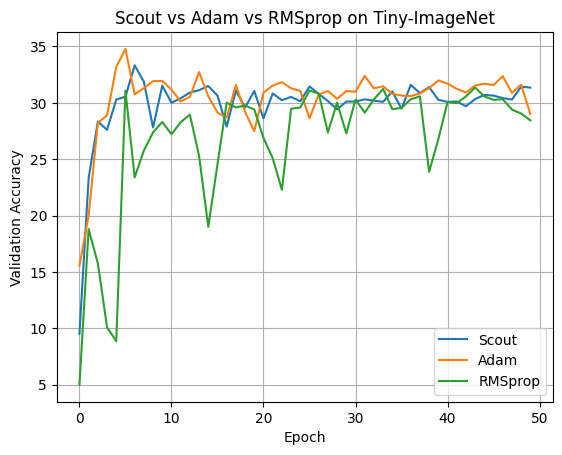

In [2]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet18
import matplotlib.pyplot as plt

# 🔒 Reproducibility: Set seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(15)  # Change this to try different random initializations

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



class ScoutOptimizer(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer_cls, scout_step_interval=5, **kwargs):
        self.base_optimizer = base_optimizer_cls(params, **kwargs)
        self.step_count = 0
        self.scout_step_interval = scout_step_interval
        self.eps = 1e-8
        self.param_groups = self.base_optimizer.param_groups

    def step(self, closure=None):
        loss = closure() if closure is not None else None
        self.step_count += 1

        grads = [p.grad.view(-1) for group in self.param_groups for p in group['params'] if p.grad is not None]
        flat_grad = torch.cat(grads)
        norm_g = flat_grad / (flat_grad.norm() + self.eps)

        rand_dir = torch.randn_like(norm_g)
        proj = torch.dot(norm_g, rand_dir) * norm_g
        ortho = rand_dir - proj
        ortho /= ortho.norm() + self.eps

        if self.step_count % self.scout_step_interval == 0:
            idx = 0
            with torch.no_grad():
                for group in self.param_groups:
                    for p in group['params']:
                        if p.grad is None:
                            continue
                        numel = p.numel()
                        noise = 0.01 * ortho[idx:idx+numel].view_as(p)
                        p.add_(noise)
                        idx += numel

        self.base_optimizer.step()
        return loss

# Define transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Adjust path to your local unzipped dataset
data_dir = r"C:\Users\Machine-Learning\Downloads\tiny-imagenet-200"
train_data = torchvision.datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform)
val_data = torchvision.datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform)


train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)

        def closure():
            if isinstance(optimizer, ScoutOptimizer):
                optimizer.base_optimizer.zero_grad()
            else:
                optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            return loss

        loss = optimizer.step(closure)
        total_loss += loss.item()
    return total_loss / len(loader)

def validate(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            _, predicted = outputs.max(1)
            total += y.size(0)
            correct += predicted.eq(y).sum().item()
    return 100. * correct / total

def get_model():
    model = resnet18(num_classes=200)
    return model.to(device)

# Initialize
scout_model = get_model()
adam_model = get_model()
rms_model = get_model()

criterion = nn.CrossEntropyLoss()
scout_optim = ScoutOptimizer(scout_model.parameters(), torch.optim.Adam, lr=1e-3, scout_step_interval=5)
adam_optim = torch.optim.Adam(adam_model.parameters(), lr=1e-3)
rms_optim = torch.optim.RMSprop(rms_model.parameters(), lr=1e-3)

scout_accs, adam_accs, rms_accs = [], [], []

# Training loop
for epoch in range(1, 51):
    train_one_epoch(scout_model, train_loader, criterion, scout_optim, device)
    train_one_epoch(adam_model, train_loader, criterion, adam_optim, device)
    train_one_epoch(rms_model, train_loader, criterion, rms_optim, device)

    scout_acc = validate(scout_model, val_loader, device)
    adam_acc = validate(adam_model, val_loader, device)
    rms_acc = validate(rms_model, val_loader, device)

    scout_accs.append(scout_acc)
    adam_accs.append(adam_acc)
    rms_accs.append(rms_acc)

    print(f"Epoch {epoch:2}:  Scout acc = {scout_acc:.2f}%  |  Adam acc = {adam_acc:.2f}%  |  RMSprop acc = {rms_acc:.2f}%")

# Plot
plt.plot(scout_accs, label='Scout')
plt.plot(adam_accs, label='Adam')
plt.plot(rms_accs, label='RMSprop')
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Scout vs Adam vs RMSprop on Tiny-ImageNet")
plt.legend()
plt.grid(True)
plt.show()
